<img src='./figs/fig1HelixRecon.png'>
<strong>Figure 1: Reconstitution of a non-linear function (tilted helix) with linear Principal Components Analysis and a neural network autoencoder (AE)</strong> PCA is only able to reconstitute a line of best fit through the center of mass of the helix, while an autoencoder is able to closely approximate the original function, even though the 1D representations from both methods are essentially the same. 

<img src='./figs/doxoSpectra.png'>
<strong>Figure 2: Average Raman spectra of MDCK cells at different days post-exposure to the cytotoxic drug doxorubicin</strong> Fluorescence background and mean signal has been subtracted from all spectra. While spontaneous Raman is a linear phenomenon, with spectral contributions increasing in direct proportion to the concentration of the corresponding chemical substances, the metabolic and physiological processes of the cell in response to stress or drugs are not necessarily linear.

<img src= ./figs/PCA64Componentsr2_831797Test.png>
<strong>Figure 2: Reconstruction of Raman spectra using PCA with R$^2$ = 0.8318 on validation spectra</strong> A stark difference in the principal component encodings generated from PCA as opposed to the neural network is the enriched variance in the first few components an intrinsic characteristic of PCA not shared with neural network autoencoders, which have no incentive to consolidate variance to only a few activations. 

<img src= './figs/AE64Componentsr2_992772Test.png'>
<strong> Figure 3: Recconstruction of Raman spectra using a neural network autoencoder with R$^2$ = 0.9927 on validation spectra </strong> Although PCA is very effective at explaing the variance in the training set (R$^2 > 0.9999$), it does not generalize as well as an AE to validation data not seen during training. Therefore an AE should be more effective for creating a searchable subspace that can be updated with new data. 

In [11]:

import sys

sys.path.append('/home/radlr/anaconda3/envs/lVGPU2/lib/python3.6/site-packages')

#hint from https://stackoverflow.com/questions/19876079/opencv-cannot-find-module-cv2
#Specifically to import my .mat files containing OT QPD traces
import scipy.io as sio
import numpy as np
import time

#Learning libraries
import sklearn 
from sklearn.manifold import TSNE
import tensorflow as tf
from tensorflow.contrib import learn
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

#pearson cor. coef.
from scipy.stats.stats import pearsonr 

#plotting imports
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from matplotlib import gridspec
myDPI = 90

#%matplotlib inline
#%config InlineBackend.figure_format = 'retina'



import colormaps


C1 = colormaps.viridis(0)
C2 = colormaps.viridis(64)
C3 = colormaps.viridis(96)
C4 = colormaps.viridis(128)
C5 = colormaps.viridis(196)
C6 = colormaps.viridis(256)


In [12]:
import matplotlib.pyplot as plt

def draw_neural_net(ax, left, right, bottom, top, layer_sizes):
    '''
    Draw a neural network cartoon using matplotilb.
    
    :usage:
        >>> fig = plt.figure(figsize=(12, 12))
        >>> draw_neural_net(fig.gca(), .1, .9, .1, .9, [4, 7, 2])
    
    :parameters:
        - ax : matplotlib.axes.AxesSubplot
            The axes on which to plot the cartoon (get e.g. by plt.gca())
        - left : float
            The center of the leftmost node(s) will be placed here
        - right : float
            The center of the rightmost node(s) will be placed here
        - bottom : float
            The center of the bottommost node(s) will be placed here
        - top : float
            The center of the topmost node(s) will be placed here
        - layer_sizes : list of int
            List of layer sizes, including input and output dimensionality
    '''
    n_layers = len(layer_sizes)
    v_spacing = (top - bottom)/float(max(layer_sizes))
    h_spacing = (right - left)/float(len(layer_sizes) - 1)
    # Nodes
    for n, layer_size in enumerate(layer_sizes):
        layer_top = v_spacing*(layer_size - 1)/2. + (top + bottom)/2.
        for m in range(layer_size):
            circle = plt.Circle((n*h_spacing + left, layer_top - m*v_spacing), v_spacing/4.,
                                color='w', ec='k', zorder=4)
            ax.add_artist(circle)
    # Edges
    for n, (layer_size_a, layer_size_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer_top_a = v_spacing*(layer_size_a - 1)/2. + (top + bottom)/2.
        layer_top_b = v_spacing*(layer_size_b - 1)/2. + (top + bottom)/2.
        for m in range(layer_size_a):
            for o in range(layer_size_b):
                line = plt.Line2D([n*h_spacing + left, (n + 1)*h_spacing + left],
                                  [layer_top_a - m*v_spacing, layer_top_b - o*v_spacing], c='k')
                ax.add_artist(line)

1024

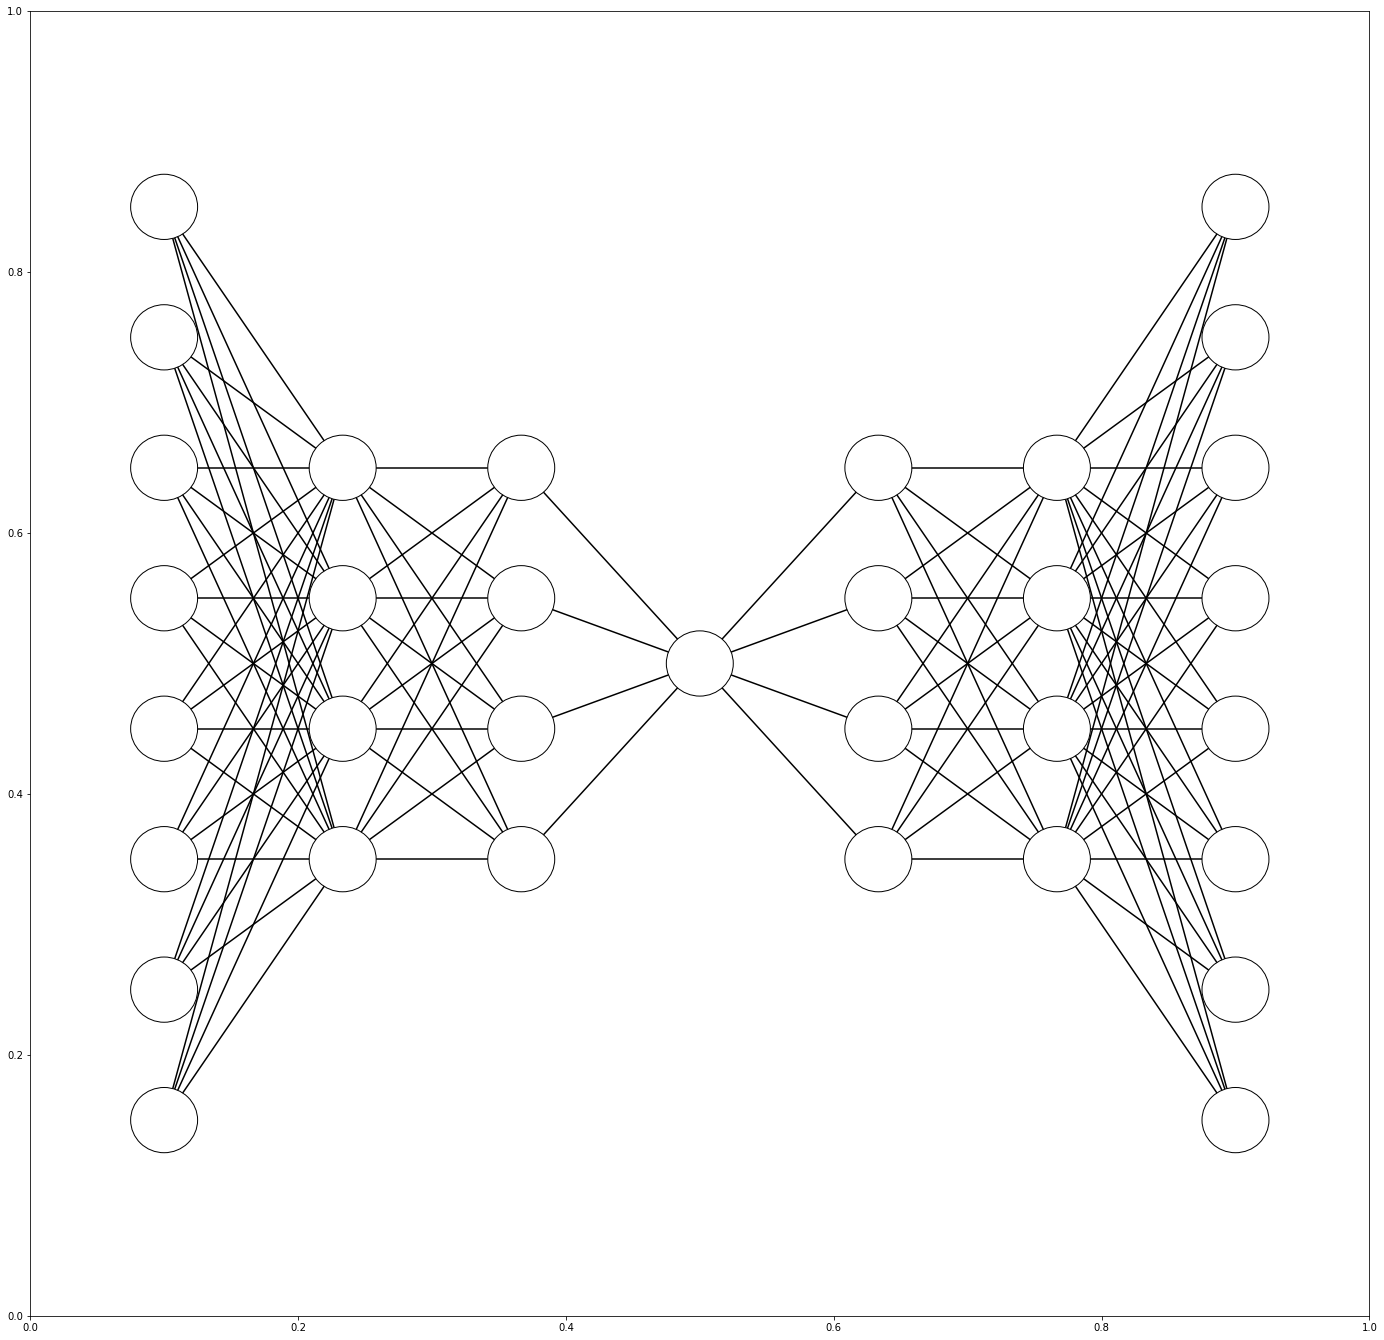

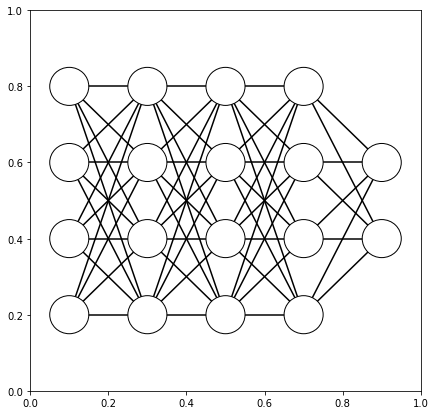

In [39]:
#draw_neural_net(ax, left, right, bottom, top, layer_sizes,Theta0,Theta1):
# https://gist.github.com/craffel/2d727968c3aaebd10359
fig = plt.figure(figsize=(24, 24))
draw_neural_net(fig.gca(), .1, .9, .1, .9, [8, 4, 4,1,4,4,8])
fig2 = plt.figure(figsize=(7, 7))
draw_neural_net(fig2.gca(), .1, .9, .1, .9, [4, 4,4,4,2])
plt.show()

In [20]:
plt.show()

In [6]:
# Define miscellaneous functions

def minMeanMax(myVector):
    print("min: %.3e, mean: %.3e, max: %.3e"%(np.min(myVector),np.mean(myVector),np.max(myVector)))
          
def helix(a,b,m,noise,T,dt):
    """Return a helix of the form
    x = a*cost(t)+m*t, y = a*sin(t)+m*t, z = b*t, from 0 to T with added noise magnitude = noise """

    t = np.arange(0,T,dt)*1.0
    myHelix = np.array([a*np.cos(t)+m*t, a*np.sin(t)+m*t,b*t])
    myHelix = np.array(myHelix) + noise*(np.random.random(np.shape(myHelix))-0.5)
    return myHelix.T

def r2(yi, fi):
    """Return the r^2 value for a computed function fi and some data yi"""
    yMean = np.mean(yi)
    yVarTot = np.sum((yi-yMean)**2)
    varRes = np.sum((yi-fi)**2)
    R2 = 1-(varRes/yVarTot)
    return R2

def MSEr(yi,fi):
    MSEr = np.mean((yi-fi)**2)
    return MSEr

def evalAcc(y,pred):
    """Function for determining accuracy of logits vs targets"""
    # y and pred must be the same size
    if( not (np.shape(y) == np.shape(pred))):
        print("Error (shapes don't match)")
    m = np.shape(y)[0]
    myAccuracy = np.mean(1.*np.argmax(y,axis=1) == np.argmax(pred,axis=1))
           
    return myAccuracy


def precRecSpec(YPred,Y):
    """Return:
    recall (truepos / (truepos+falseneg),
    precision (truepos/(truepos+falsepos)),
    specificity (trueneg/(trueneg+falsepos))
    Assumes a two category predictions and labels vector (YPred and Y) where first cat. is positive"""
    #Calculate true/false pos/neg categories
    
    for c in range(len(YPred)):
        YPred[c,np.argmax(YPred[c,:])] = 1.
        YPred[c,np.argmin(YPred[c,:])] = 0.
        
    truepos = np.sum((np.argmax(YPred,axis=1) == 0) & (np.argmax(Y,axis=1)==0))
    trueneg = np.sum((np.argmax(YPred,axis=1) == 1) & (np.argmax(Y,axis=1)==1))#np.sum(YPred[:,1] == Y[:,1])
    
    totpos = np.sum(Y[:,0])
    totneg = np.sum(Y[:,1])
    
    falseneg = totpos-truepos
    falsepos = totneg-trueneg
    
    popTotal = totpos+totneg
    
    #calculate metrics
    myAccuracy = (truepos+trueneg) / popTotal
    myPrecision = truepos / (truepos+falsepos) #
    myRecall = truepos / (truepos+falseneg) # Aka sensitivity 
    mySpecificity =  trueneg / (trueneg+falsepos)
    
    return myAccuracy, myPrecision, myRecall, mySpecificity

[('DoxorubicinMatrix1', (156, 1798), 'double')]
(156, 1798)
(64, 5)
Data from doxorubicin experiment has been read in , number of classes = 5, spectra length = 1798
(1798,)


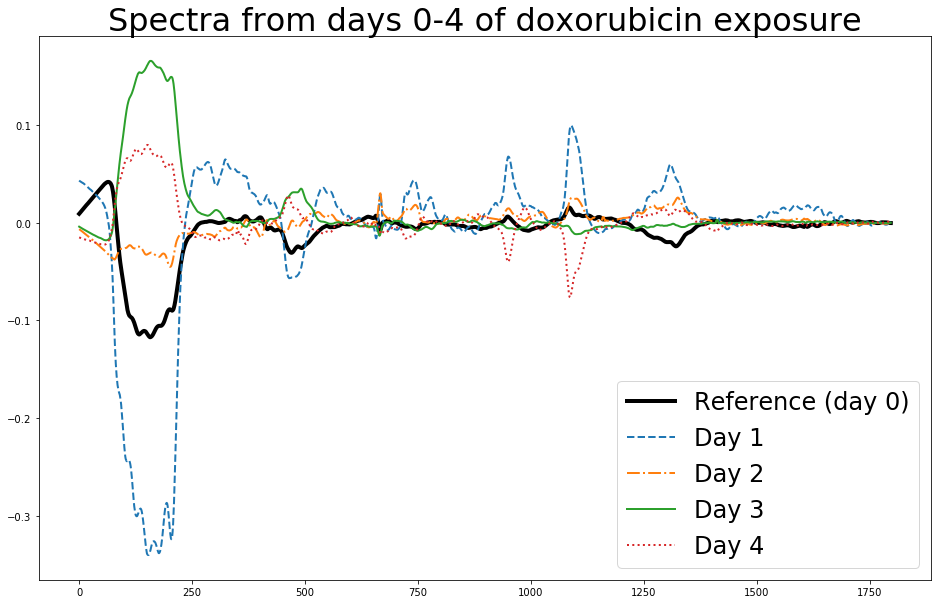

In [7]:

mySeed =1337
myTrunc = 0

if (0): #DU145/PNT2 study
    print(sio.whosmat('./du145ANDPNT2/PNT2_DU145_MatrixConnected.mat'))
    myData = sio.loadmat('./du145ANDPNT2/PNT2_DU145_MatrixConnected.mat')
    X1 = myData['BGCorrectedMatrixDU145']
    X2 = myData['BGCorrectedMatrixPNT2']
    print("DU145 vector size %i by %i"%(np.shape(X1)[0],np.shape(X1)[1]))
    print("PNT2 vector size %i by %i"%(np.shape(X2)[0],np.shape(X2)[1]))
    
    myNumClasses = 2

    X1 = X1.T
    X2 = X2.T
    X1 = X1[:,myTrunc:np.shape(X1)[1]]
    X2 = X2[:,myTrunc:np.shape(X2)[1]]
    XDP = np.append(X1,X2,axis=0)
    XDP[np.isnan(XDP)]=0.0
    print(np.shape(XDP))

    #XDP = (XDP/np.max(XDP))
    #XDP = 2*(XDP-np.mean(XDP))

    print('Setting up target classes ..  .. .. ')
    YDP = np.zeros((141,myNumClasses)) 
    YDP[0:76,:] = [1,0]
    YDP[76:141,:] = [0,1]
    print(YDP[73:78,:])




    print("Data ready . . .")

    #get rid of a few nonsense spectra
    myBadIndex = [0,76]

    print(np.shape(XDP))
    XDP = np.delete(XDP,myBadIndex,axis=0)
    YDP = np.delete(YDP,myBadIndex,axis=0)


    #Normalize and shift spectra
    if(1):
        for c in range(np.shape(XDP)[0]):
            XDP[c,:] = 2*((XDP[c,:]-np.min(XDP[c,:]))/np.max((XDP[c,:]-np.min(XDP[c,:])))-0.5)


    np.random.seed(mySeed)
    np.random.shuffle(XDP)
    np.random.seed(mySeed)
    np.random.shuffle(YDP)


    trainXDP = XDP[1:121,:]
    trainYDP = YDP[1:121,:]
    testXDP = XDP[121:141,:]
    testYDP = YDP[121:141,:]
    myClassess = [[0,1],[0,1]]
    # Define Model Par,ameters
    # Parsing layer sizes
    myHL1 = HLP1
    myHL = HLP1
    # Encoding layer size
    myHLCode = 64
    # Synthesis layer sizes
    myHL9 = HLS9

    # Classification arm layer sizes
    myHLC = HLC
    myNumClasses = np.shape(YDP)[1]
    nVisible = np.shape(XDP)[1]
    
if(1): # Doxorubicin exposure of THP cells study
    print(sio.whosmat('./doxorubicinToxicity/FullMatrix.mat'))
    myData = sio.loadmat(('./doxorubicinToxicity/FullMatrix.mat'))
    
    X = myData['DoxorubicinMatrix1']
    #Downsize sample a bit
    print(np.shape(X))
    
    X = X[:,myTrunc:np.shape(X)[1]]
    X = (X/np.max(X))
    X = 2*(X-np.mean(X))

    #X=np.copy(myX)
    #Normalise the data
    #X = X/ np.max(X)
    #Allocate and shuffle the data
    if (1):
        myNumClasses=5
        Y = np.zeros([156,myNumClasses])
        Y[0:52,:] = [1,0,0,0,0] # reference
        Y[53:60,:] = [0,1,0,0,0] # Day one
        Y[60:90,:] = [0,0,1,0,0] # Day two
        Y[90:128,:] = [0,0,0,1,0] # Day three
        Y[128:156,:] = [0,0,0,0,1] # Day four
        y = np.copy(Y) # will use this later
        myClassess = [[1,0,0,0,0],[0,1,0,0,0],[0,0,1,0,0],[0,0,0,1,0],[0,0,0,0,1]]
        
    elif(0):
        Y = np.zeros([156,3])
        Y[0:52,:] = [1,0,1]
        Y[60:90,:] = [0,1,0]
        Y[90::156,:] = [0,0,1]
    elif(0):
        Y = np.zeros([156,2])
        Y[0:52,:] = [1,0]
        Y[53:156,:] = [0,1]
        Y[53:156,:] = [0,1] #
    
    avgSpectra0 = np.mean(X[0:52,:],axis=0)
    avgSpectra1 = np.mean(X[53:60,:],axis=0)
    avgSpectra2 = np.mean(X[60:90,:],axis=0)
    avgSpectra3 = np.mean(X[90:128,:],axis=0)
    avgSpectra4 = np.mean(X[128:156,:],axis=0)
    
    np.random.seed(1337)
    np.random.shuffle(Y)
    np.random.seed(1337)
    np.random.shuffle(X)

    trainX = X[0:92,:]
    trainY = Y[0:92,:]
    testX = X[92:156,:]
    testY = Y[92:156,:]
    XFull = np.copy(X)
    YFull = np.copy(Y)
    print(np.shape(testY))
    # Length of spectra
    nVisible = np.shape(X)[1]
    myNumClasses = np.shape(Y)[1]
    print('Data from doxorubicin experiment has been read in , number of classes = %i, spectra length = %i'%(myNumClasses,nVisible))
    #Now set up data from second experiment
    
# Average spectra and display

avgSpectra = np.mean(X,axis=0)
print(np.shape(avgSpectra))
plt.figure(figsize=(16,10))
#plt.plot(X.T)
plt.plot(avgSpectra0,color='k',lw=4)
plt.plot(avgSpectra1,'--',lw=2)
plt.plot(avgSpectra2,'-.',lw=2)
plt.plot(avgSpectra3,'-',lw=2)
plt.plot(avgSpectra4,':',lw=2)
#plt.axis([-20,1900,-0.20,0.125])
plt.title('Spectra from days 0-4 of doxorubicin exposure',fontsize=32)
plt.legend(['Reference (day 0)','Day 1','Day 2', 'Day 3', 'Day 4'],loc=4,fontsize=24)
plt.show()

In [8]:
# Fig. 4: PCA vs AE reconstitution

""" Neural network for simultaneous training as an autoencoder and classifier for non-linear PCA encoding and discerning signature features of Raman spectra in different conditions (drug-challenged cells, e.g. incubated with doxirubicin. 

Classification Arm (Central encoding feeds into classification)
             .....
              \ / 
              ___

              ___
                  
              ___ 
 
              ___
                
 |             ^            |
 |   |   |          |   |   |
 |   |   |     |    |   |   |
 |   |   |          |   |   |
 |                          | 
 
Autoencoder arm transforms Raman spectra input to a reduced encoding

             5  Classes
             ^
            256
		     ^
            256
             ^
            256
             ^ 
            256         1298 Outputs (reconstituted Raman spectra)  
             ^           ^
1024>512>512>64>512>512>1024
 ^
1298 Inputs (Raman spectra)

"""
#learning rates
lRC = 1e-5
lRAE = 1e-5
lRDecay = 1 - 1e-3

#training iterations
epochs = 600
dispIt = 60

#layer sizes
HLP1 = 1024
HLS9 = HLP1
HLP = 512
HLC = 256
myHL1 = HLP1
myHL = HLP1
myHLCode = 64
myHLC = HLC
inputs = tf.placeholder("float",[None,nVisible])
classTargets = tf.placeholder("float",[None,myNumClasses])
myClasses = tf.placeholder("float",[None,myNumClasses])
#aETargets = tf.placeholder("float",[None,nVisible])

# Set up weights and biases

# Encoding weights
w1 = tf.Variable(tf.truncated_normal([nVisible,myHL1],stddev=0.05),name='w1')
w2 = tf.Variable(tf.truncated_normal([myHL1,myHL],stddev=0.05),name='w2')
w3 = tf.Variable(tf.truncated_normal([myHL,myHL],stddev=0.05),name='w3')
w4 = tf.Variable(tf.truncated_normal([myHL,myHL],stddev=0.05),name='w4')
wCode = tf.Variable(tf.truncated_normal([myHL,myHLCode],stddev=0.05),name='wC')
#wCode = tf.Variable(myXRaman,dtype='float32',name='wC')
#Reconstruction weights
w6 = tf.Variable(tf.truncated_normal([myHLCode,myHL],stddev=0.05),name='w6')
w7 = tf.Variable(tf.truncated_normal([myHL,myHL],stddev=0.05),name='w7')
w8 = tf.Variable(tf.truncated_normal([myHL,myHL],stddev=0.05),name='w8')
w9 = tf.Variable(tf.truncated_normal([myHL,myHL1],stddev=0.05),name='w9')
w10 = tf.Variable(tf.truncated_normal([myHL1,nVisible],stddev=0.05),name='w10')

# Classification-only weights
wC6 = tf.Variable(tf.truncated_normal([myHLCode,myHLC],stddev=0.05),name='wC6')
wC7 = tf.Variable(tf.truncated_normal([myHLC,myHLC],stddev=0.05),name='wC7')
wC8 = tf.Variable(tf.truncated_normal([myHLC,myHLC],stddev=0.05),name='wC8')
wC9 = tf.Variable(tf.truncated_normal([myHLC,myHLC],stddev=0.05),name='wC9')
wC10 =  tf.Variable(tf.truncated_normal([myHLC,myNumClasses],stddev=0.05),name='wC10')

# For now I'm not using any biases

def ramaeNN(inputs,classesTargets):
	"""autoencoder/classifier"""
	# Encode input
	data1 = tf.reshape(inputs,[-1,nVisible])
	H1 = tf.nn.tanh(tf.matmul(data1,w1))
	H2 = tf.nn.tanh(tf.matmul(H1,w2))
	H3 = tf.nn.tanh(tf.matmul(H2,w3))
	#H4 = tf.nn.tanh(tf.matmul(H3,w4))
	myCode = tf.nn.tanh(tf.matmul(H3,wCode))
	# Synthesize reconstruction
	H6 = tf.nn.tanh(tf.matmul(myCode,w6))
	H7 = tf.nn.tanh(tf.matmul(H6,w7))
	H8 = tf.nn.tanh(tf.matmul(H7,w8))
	#H9 = tf.nn.tanh(tf.matmul(H8,w9))
	myRecon = (tf.matmul(H8,w10))

	# Make prediction
	HC6 = tf.nn.tanh(tf.matmul(myCode,wC6))
	HC7 = tf.nn.tanh(tf.matmul(HC6,wC7))
	HC8 = tf.nn.tanh(tf.matmul(HC7,wC8))
	HC9 = tf.nn.tanh(tf.matmul(HC6,wC9))
	myPred = tf.nn.softmax(tf.matmul(HC9,wC10))
	
	return myRecon, myPred, myCode 

def NNeamar(myClasses):
	"""Spectra from classes generator. This model inverts the classifier arm to generate 'fingerprints' of the important features used by the network to classify spectra"""
	
	#myClasses = float(myClasses)#tf.Variable(myClasses,dtype=tf.float32)
	HC9Prime = tf.nn.tanh(tf.matmul(myClasses,tf.transpose(wC10)))
	HC8Prime = tf.nn.tanh(tf.matmul(HC9Prime,tf.transpose(wC9)))
	HC7Prime = tf.nn.tanh(tf.matmul(HC8Prime,tf.transpose(wC8))) 
	HC6Prime = tf.nn.tanh(tf.matmul(HC7Prime,tf.transpose(wC7)))
	#H4Prime
	#H3Prime
	myCodePrime = tf.nn.tanh(tf.matmul(HC7Prime,tf.transpose(wC6)))
	H2Prime = tf.nn.tanh(tf.matmul(myCodePrime,tf.transpose(wCode)))
	H1Prime = tf.nn.tanh(tf.matmul(H2Prime,tf.transpose(w2)))
	myGen = tf.matmul(H1Prime,tf.transpose(w1))
	return myGen


myRecon, myPred, myCode = ramaeNN(inputs,classTargets)
myGen = NNeamar(myClasses)

aELoss = tf.reduce_mean(tf.pow((inputs-myRecon),2))
cLoss = tf.reduce_mean(tf.losses.softmax_cross_entropy(onehot_labels = classTargets, logits = myPred))
cVar = [wC6, wC7, wC8, wC9, wC10]

aETrainOp = tf.train.AdamOptimizer(learning_rate=lRAE,
                                 beta1=0.9,
                                 beta2 = 0.999,
                                 epsilon=1e-08,
                                 use_locking=False,
                                 name='aEAdam').minimize(aELoss)

cTrainOp = tf.train.AdamOptimizer(learning_rate=lRC,
                                 beta1=0.9,
                                 beta2 = 0.999,
                                 epsilon=1e-08,
                                 use_locking=False,
                                 name='cAdam').minimize(cLoss)
cTrainOpFreeze = tf.train.AdamOptimizer(learning_rate=lRC,
                                 beta1=0.9,
                                 beta2 = 0.999,
                                 epsilon=1e-08,
                                 use_locking=False,
                                 name='cAdam').minimize(cLoss,var_list=cVar)
print('model ready')
autoEncLoss = tf.summary.scalar("aELoss",aELoss)
classLoss = tf.summary.scalar("cLoss",cLoss)


###### Add saver functions here
mySaverRaman = tf.train.Saver()


model ready


[[ 1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.]]


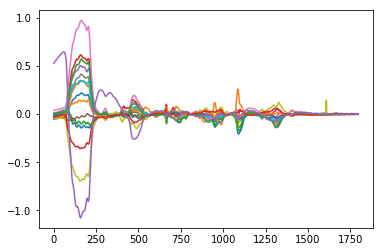

In [28]:
np.shape(testX)
np.mean(testY,axis=0)
np.sum(testY,axis=0)
testDay0 = np.zeros((15,1798))
testDay1 = np.zeros((1,1798))
testDay2 = np.zeros((14,1798))
testDay3 = np.zeros((19,1798))
testDay4 = np.zeros((15,1798))

testDay0Y = np.zeros((15,5))
testDay1Y = np.zeros((1,5))
testDay2Y = np.zeros((14,5))
testDay3Y = np.zeros((19,5))
testDay4Y = np.zeros((15,5))

day0Count = 0
day1Count = 0
day2Count = 0
day3Count = 0
day4Count = 0

for ck in range(len(testY)):
    if (testY[ck,0] ==1):
        testDay0[day0Count,:] = testX[ck,:]
        testDay0Y[day0Count,:] = testY[ck,:]
        day0Count = day0Count +1
    elif (testY[ck,1] ==1):
        testDay1[day1Count,:] = testX[ck,:]
        testDay1Y[day1Count,:] = testY[ck,:]
        day1Count = day1Count +1
    elif (testY[ck,2] ==1):
        testDay2[day2Count,:] = testX[ck,:]
        testDay2Y[day2Count,:] = testY[ck,:]
        day2Count = day2Count +1
    elif (testY[ck,3] ==1):
        testDay3[day3Count,:] = testX[ck,:]
        testDay3Y[day3Count,:] = testY[ck,:]
        day3Count = day3Count +1
    else:# (testY[ck,4] ==1):
        testDay4[day4Count,:] = testX[ck,:]
        testDay4Y[day4Count,:] = testY[ck,:]
        day4Count = day4Count +1
print(testDay0Y)
plt.figure()
plt.plot(testDay0.T)
        
plt.show()

Instructions for updating:
Use `tf.global_variables_initializer` instead.
INFO:tensorflow:Restoring parameters from ./models/doxo/-0
learning rate decayed to 9.990000e-03 (classification) and 1.000000e-03 (autoencoding)
Training classification loss epoch 0 = 1.19498e+00, accuracy = 0.6875
Autoencoding loss epoch 0 = 1.01001e-04 
r^2 for AE = 9.923184043e-01
Elapsed time:  1.50734543800354  s
(5, 1798)
highest variance at  29
second highest variance activation =  53
(64,)


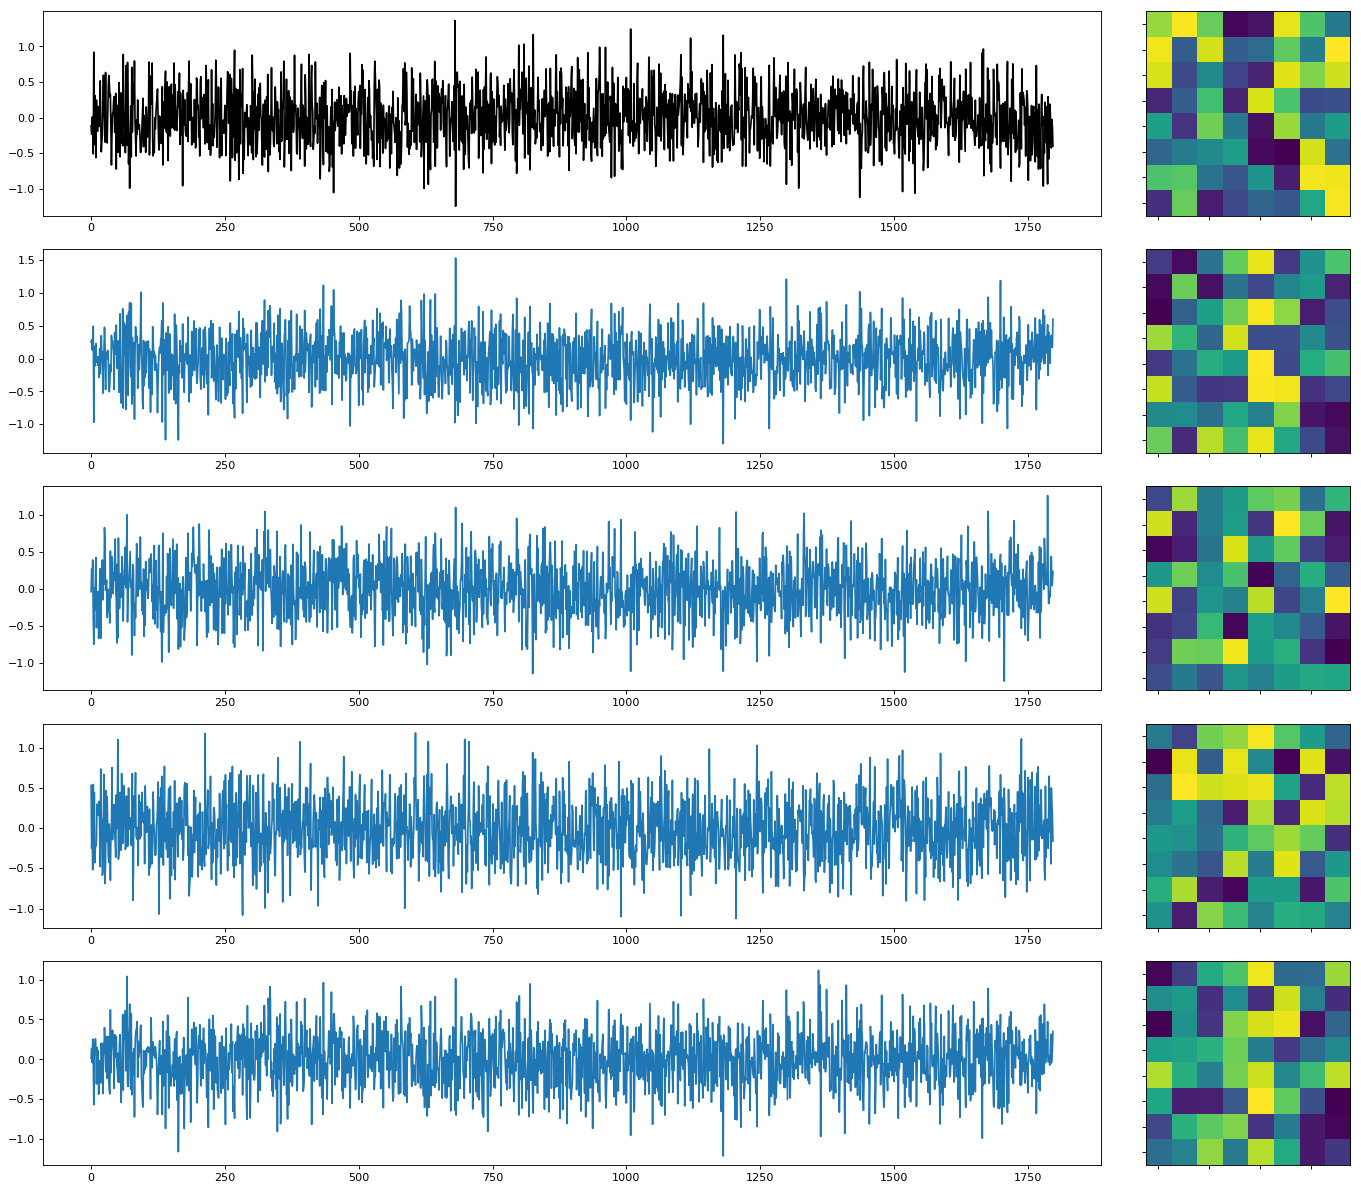

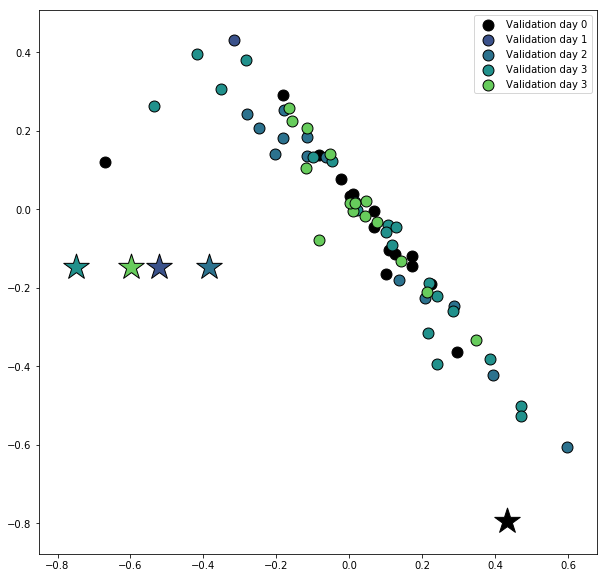

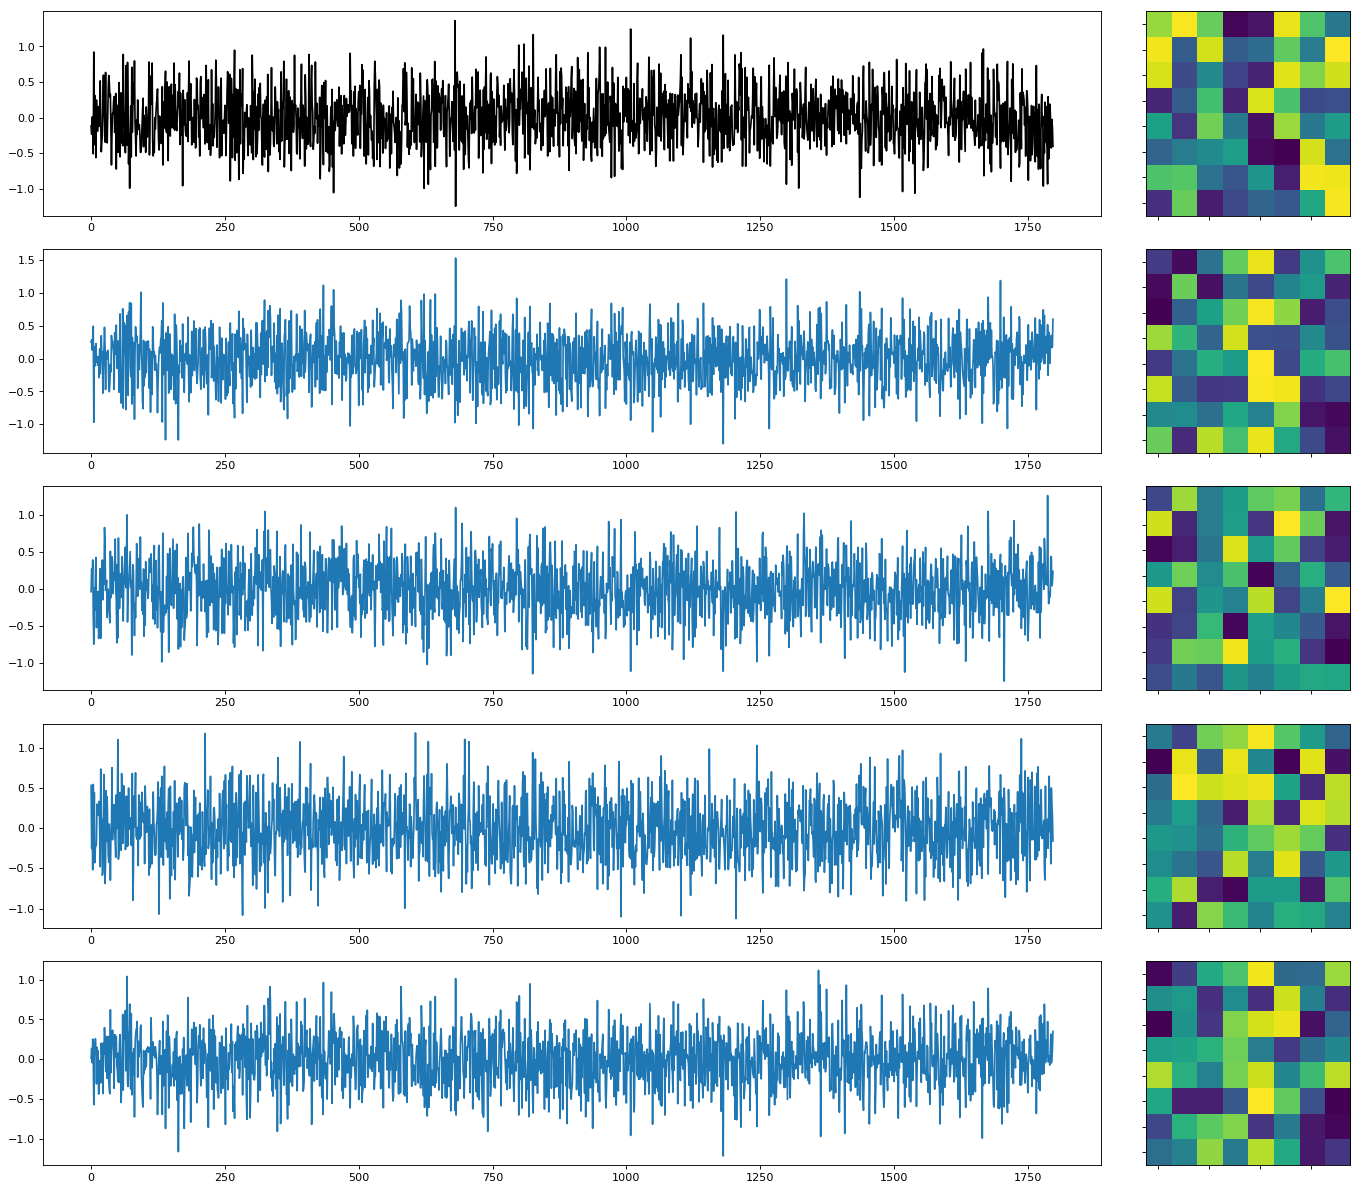

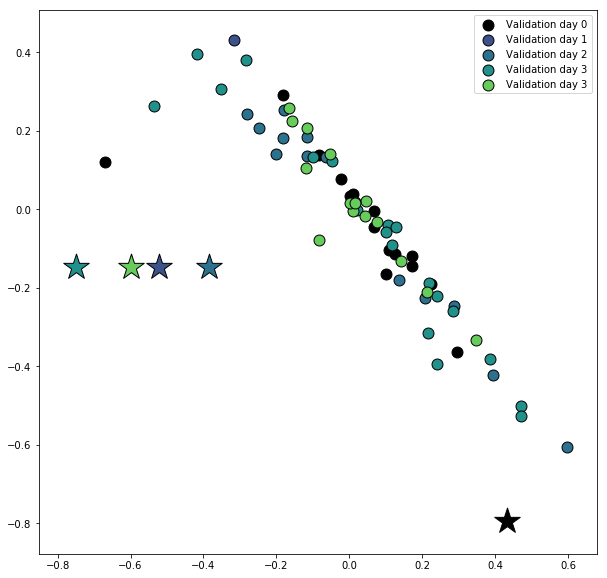

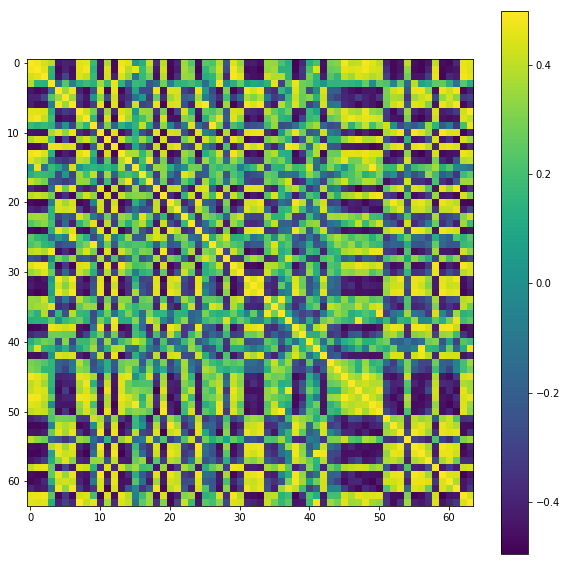

0

 distance from reference to day 0 spectral fingerprint = 0.00000e+00

 distance from reference to day 1 spectral fingerprint = 9.19927e+00

 distance from reference to day 2 spectral fingerprint = 7.26290e+00

 distance from reference to day 3 spectral fingerprint = 7.96738e+00

 distance from reference to day 4 spectral fingerprint = 8.27226e+00
learning rate decayed to 9.890548e-03 (classification) and 1.000000e-03 (autoencoding)
Training classification loss epoch 10 = 1.19460e+00, accuracy = 0.6875
Autoencoding loss epoch 10 = 1.01001e-04 
r^2 for AE = 9.923184043e-01
Elapsed time:  10.912450551986694  s
(5, 1798)
highest variance at  29
second highest variance activation =  53
(64,)


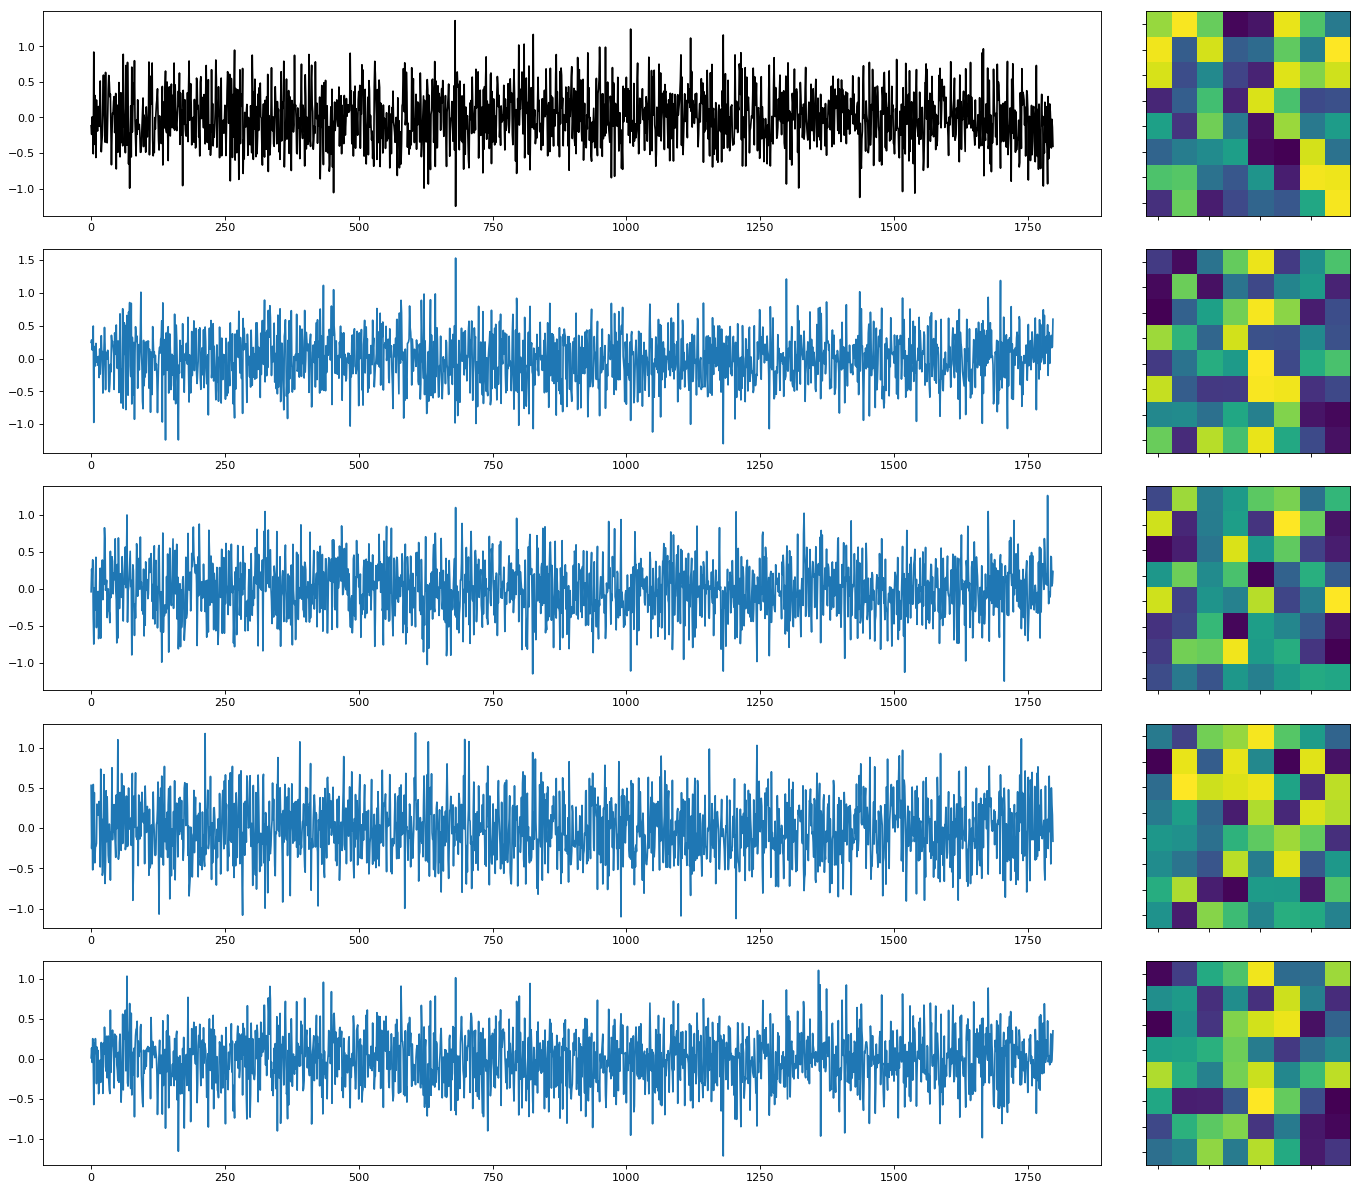

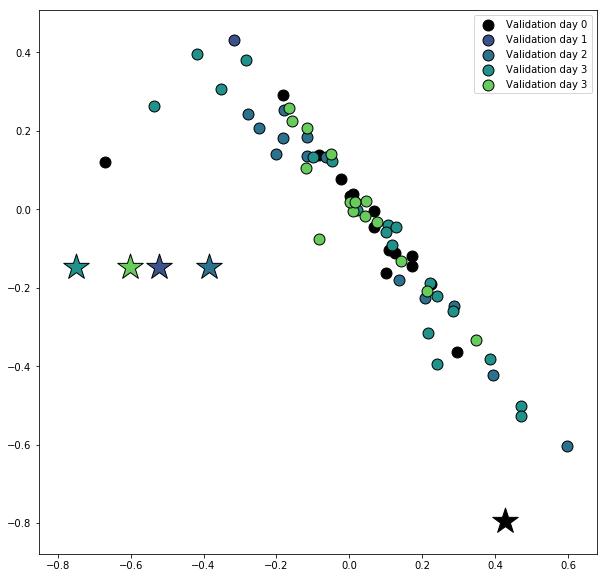

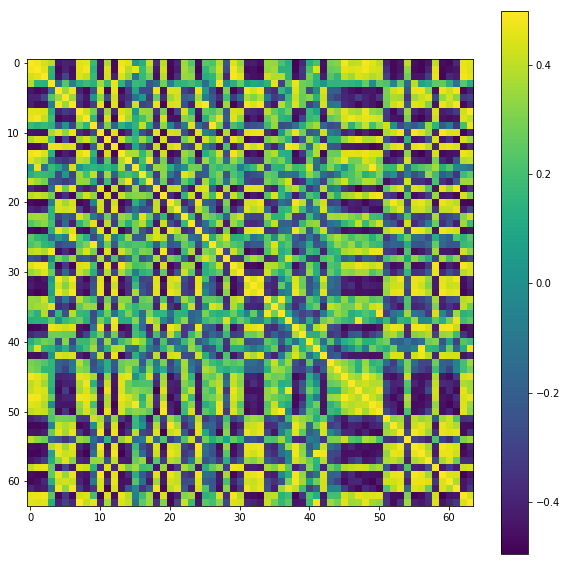

0

 distance from reference to day 0 spectral fingerprint = 0.00000e+00

 distance from reference to day 1 spectral fingerprint = 9.20227e+00

 distance from reference to day 2 spectral fingerprint = 7.24896e+00

 distance from reference to day 3 spectral fingerprint = 7.96537e+00

 distance from reference to day 4 spectral fingerprint = 8.28404e+00
learning rate decayed to 9.792087e-03 (classification) and 1.000000e-03 (autoencoding)
Training classification loss epoch 20 = 1.19452e+00, accuracy = 0.6875
Autoencoding loss epoch 20 = 1.01001e-04 
r^2 for AE = 9.923184043e-01
Elapsed time:  18.51961898803711  s
(5, 1798)
highest variance at  29
second highest variance activation =  53
(64,)


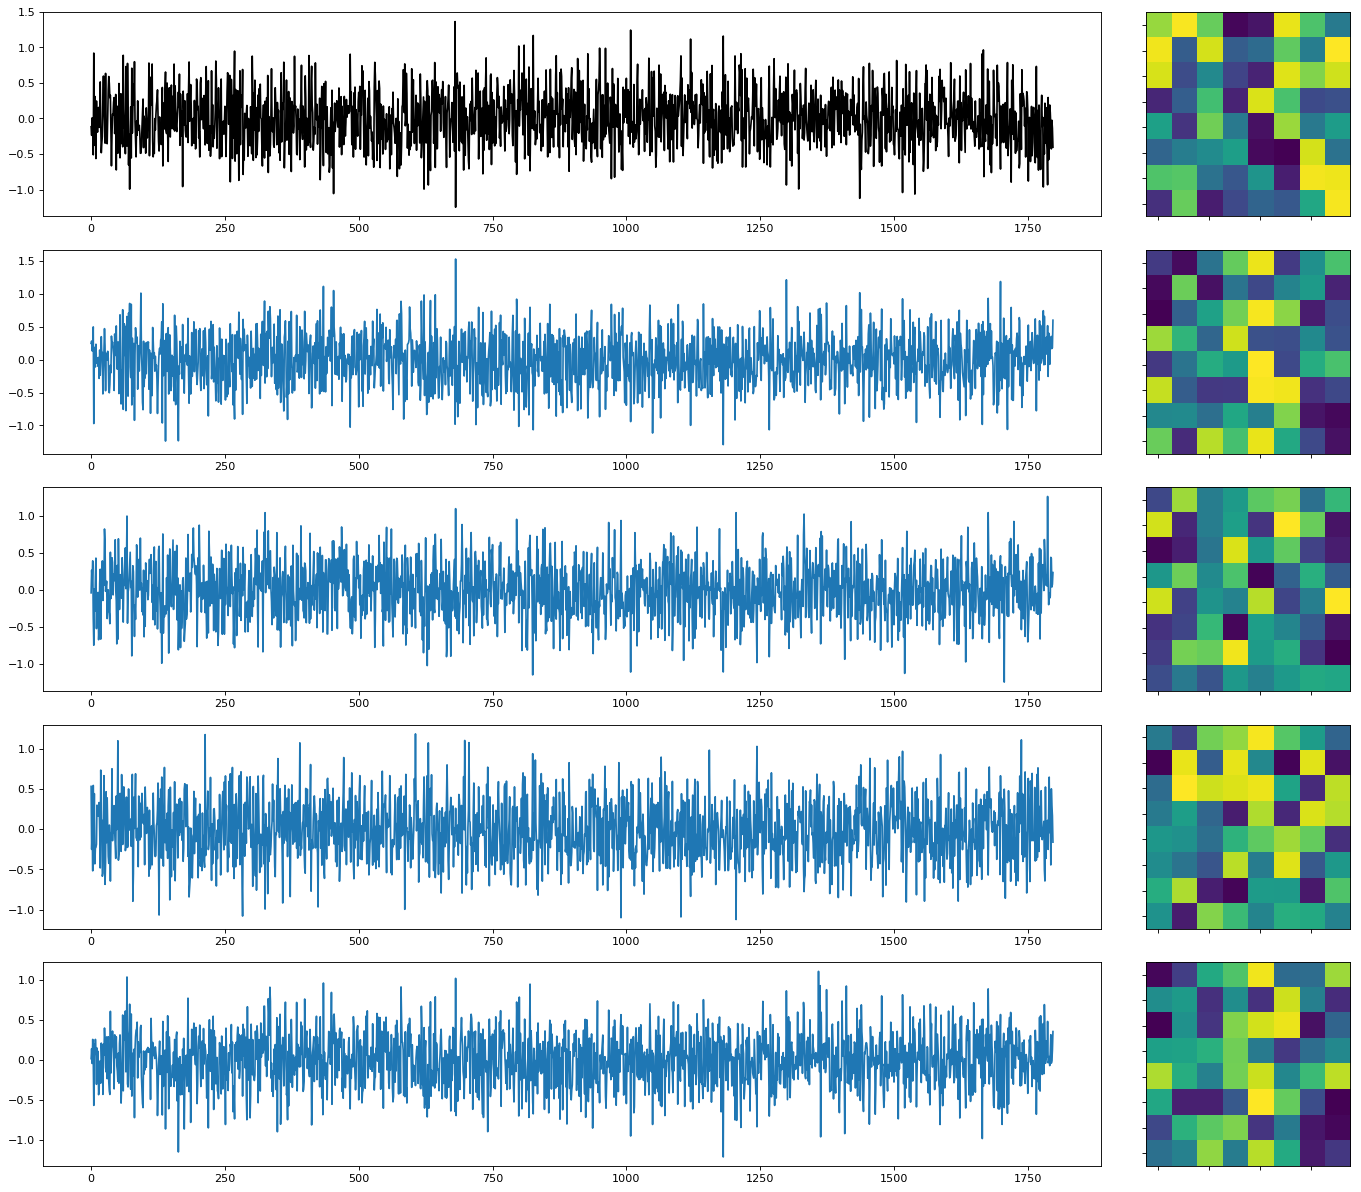

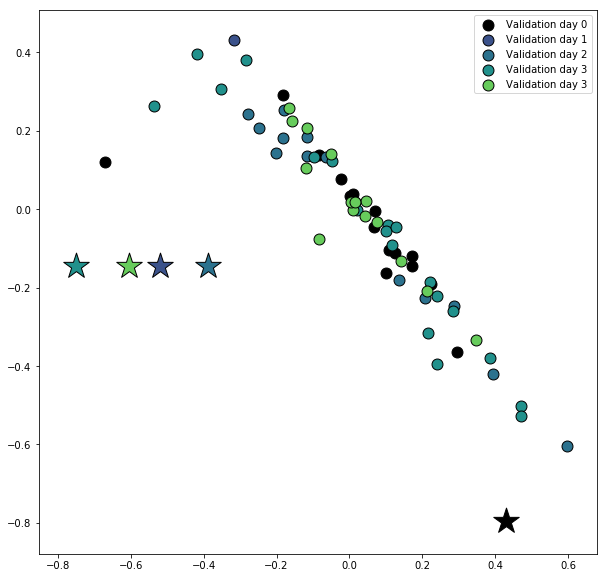

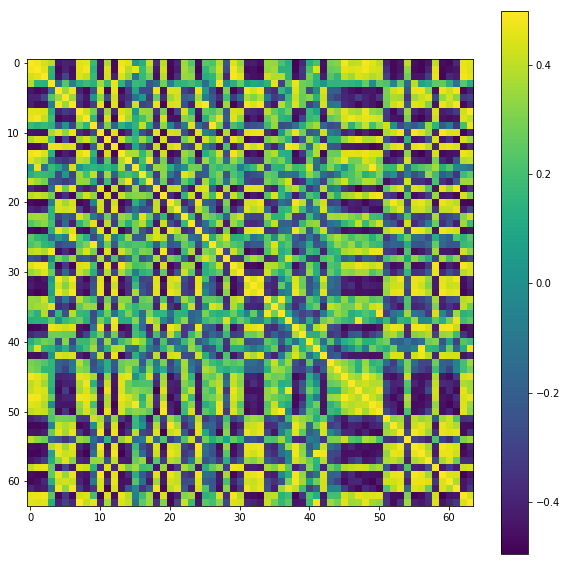

0

 distance from reference to day 0 spectral fingerprint = 0.00000e+00

 distance from reference to day 1 spectral fingerprint = 9.20700e+00

 distance from reference to day 2 spectral fingerprint = 7.24919e+00

 distance from reference to day 3 spectral fingerprint = 7.96696e+00

 distance from reference to day 4 spectral fingerprint = 8.28958e+00
learning rate decayed to 9.694605e-03 (classification) and 1.000000e-03 (autoencoding)
Training classification loss epoch 30 = 1.19450e+00, accuracy = 0.6875
Autoencoding loss epoch 30 = 1.01001e-04 
r^2 for AE = 9.923184043e-01
Elapsed time:  24.981226444244385  s
(5, 1798)
highest variance at  29
second highest variance activation =  53
(64,)


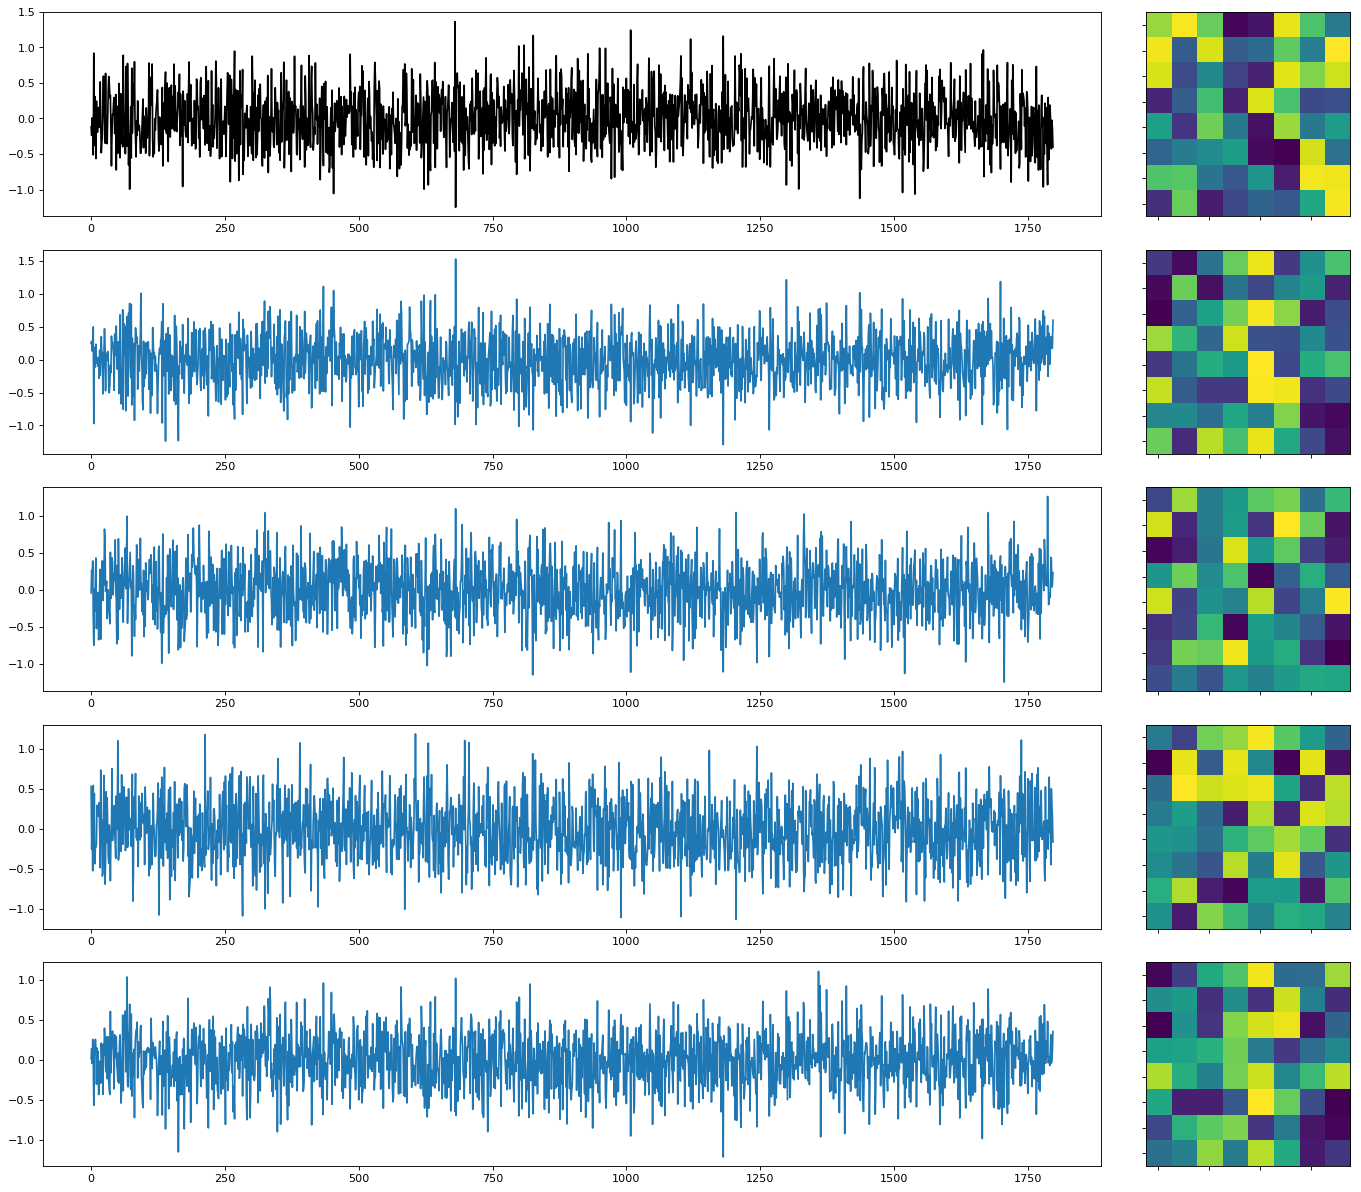

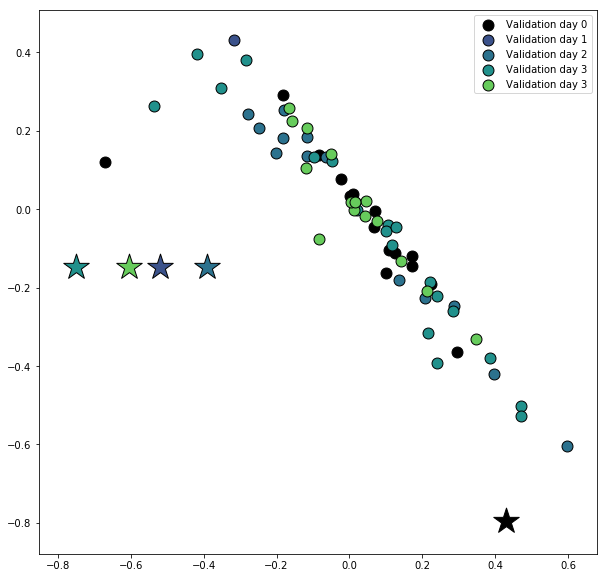

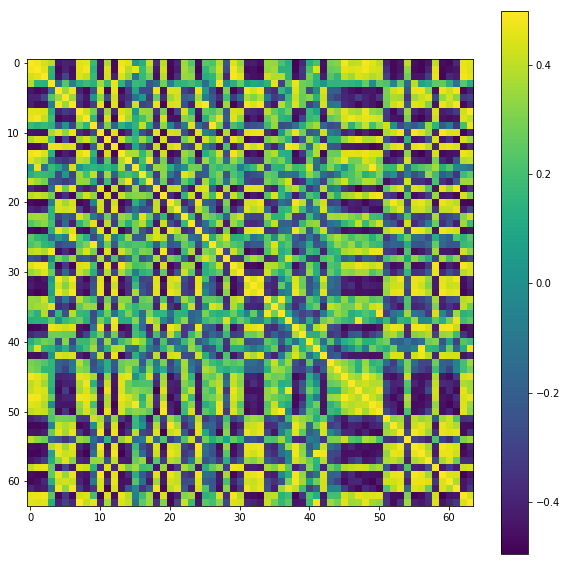

0

 distance from reference to day 0 spectral fingerprint = 0.00000e+00

 distance from reference to day 1 spectral fingerprint = 9.20876e+00

 distance from reference to day 2 spectral fingerprint = 7.25042e+00

 distance from reference to day 3 spectral fingerprint = 7.96251e+00

 distance from reference to day 4 spectral fingerprint = 8.29043e+00
learning rate decayed to 9.598094e-03 (classification) and 1.000000e-03 (autoencoding)
Training classification loss epoch 40 = 1.19448e+00, accuracy = 0.6875
Autoencoding loss epoch 40 = 1.01001e-04 
r^2 for AE = 9.923184043e-01
Elapsed time:  30.705760717391968  s
(5, 1798)
highest variance at  29
second highest variance activation =  53
(64,)


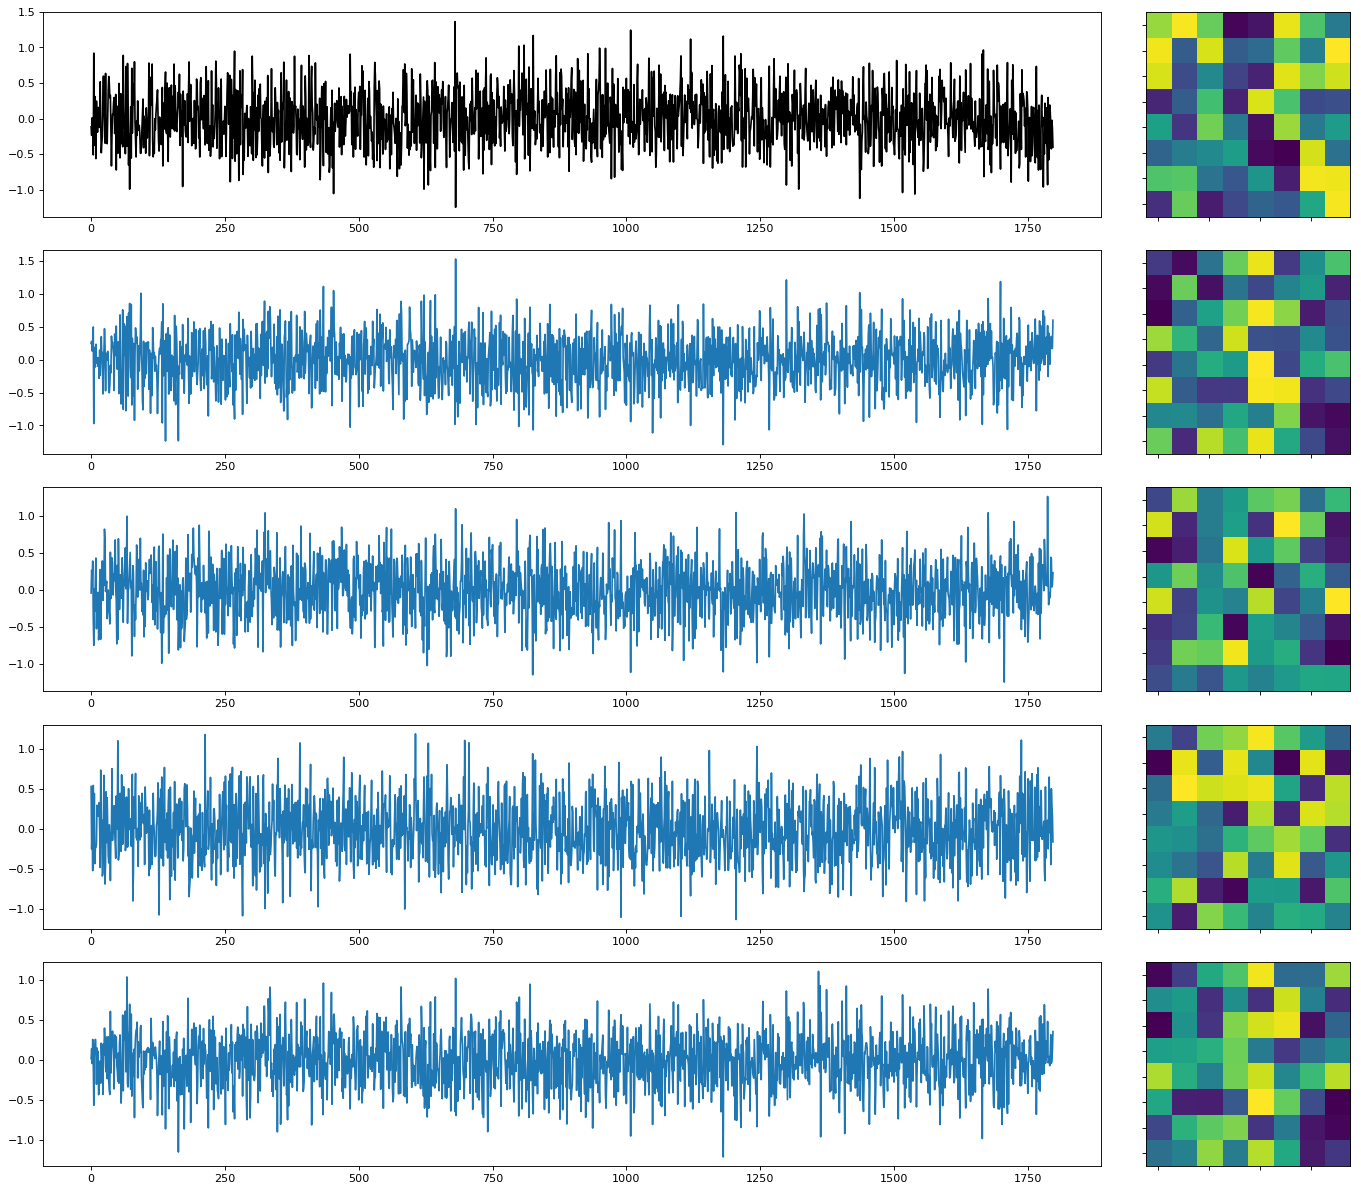

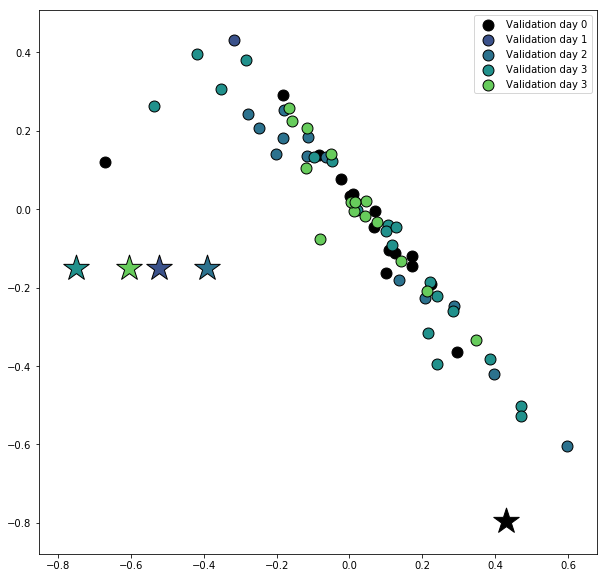

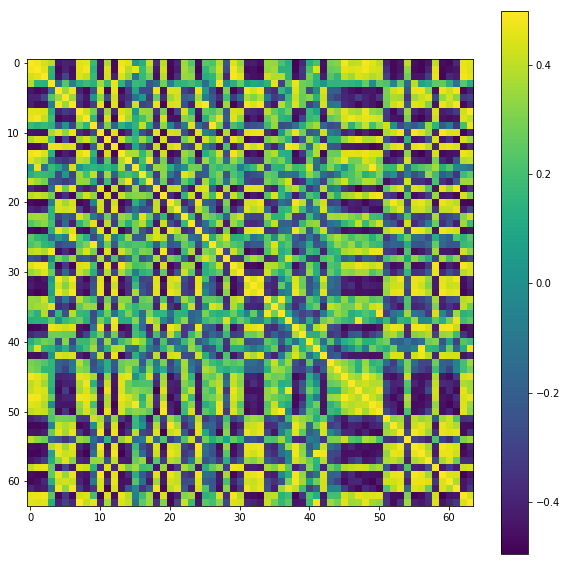

0

 distance from reference to day 0 spectral fingerprint = 0.00000e+00

 distance from reference to day 1 spectral fingerprint = 9.20895e+00

 distance from reference to day 2 spectral fingerprint = 7.25563e+00

 distance from reference to day 3 spectral fingerprint = 7.95875e+00

 distance from reference to day 4 spectral fingerprint = 8.28979e+00
learning rate decayed to 9.502544e-03 (classification) and 1.000000e-03 (autoencoding)
Training classification loss epoch 50 = 1.19447e+00, accuracy = 0.6875
Autoencoding loss epoch 50 = 1.01001e-04 
r^2 for AE = 9.923184043e-01
Elapsed time:  37.82408308982849  s
(5, 1798)
highest variance at  29
second highest variance activation =  53
(64,)


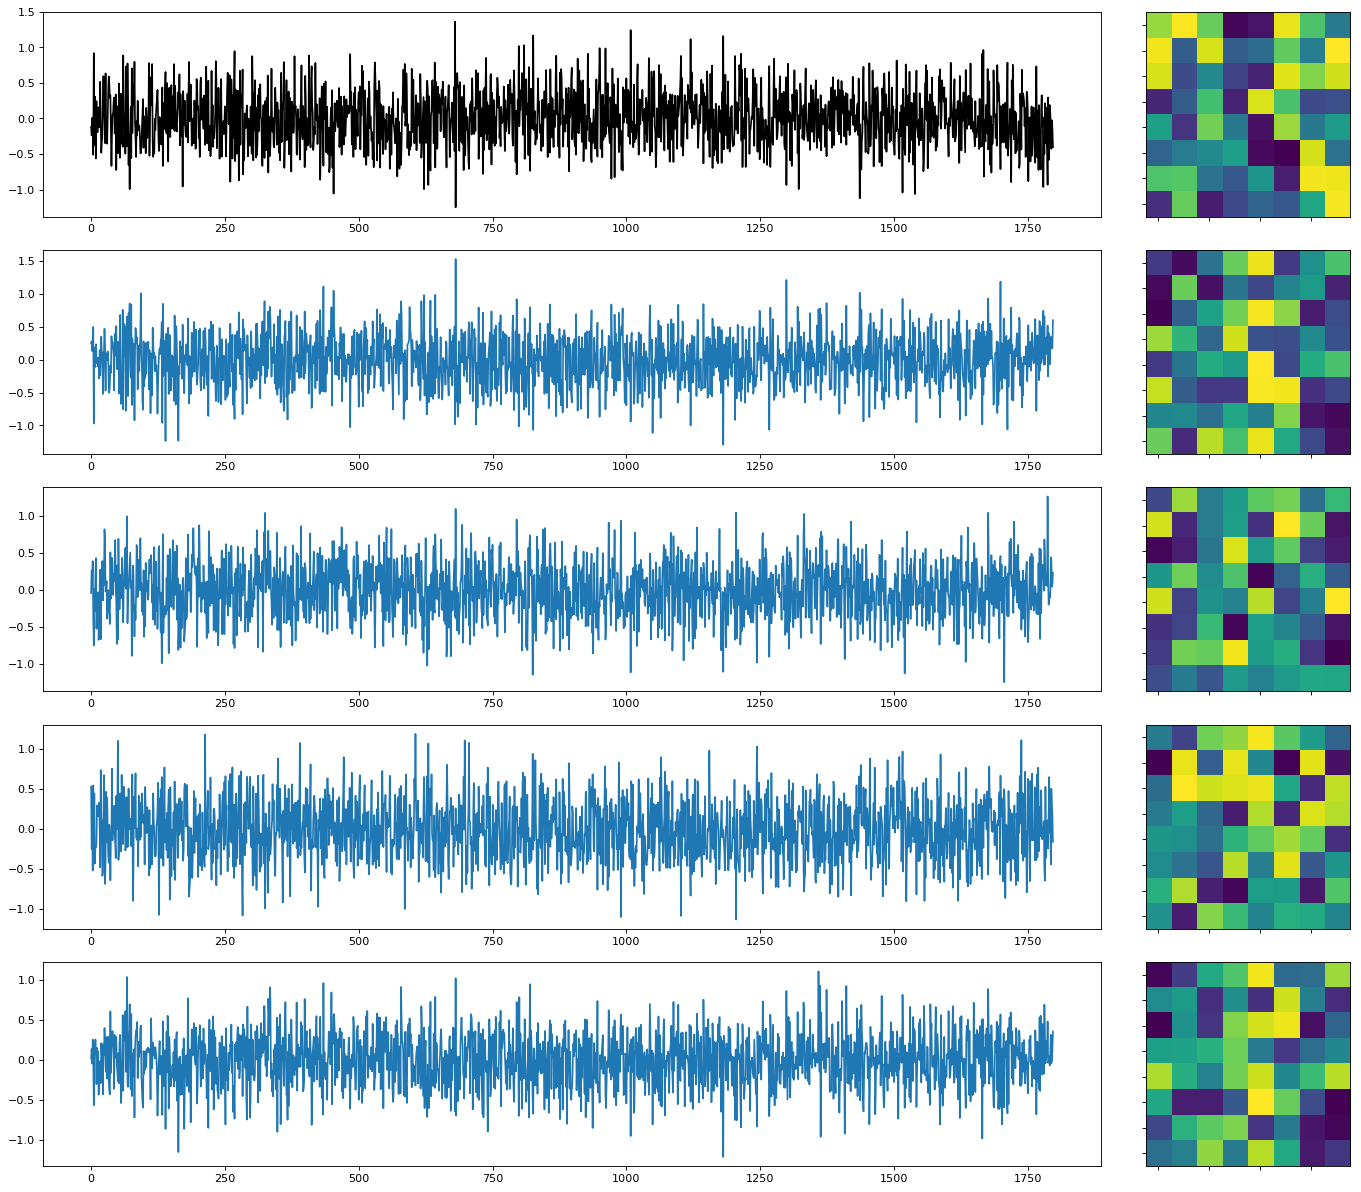

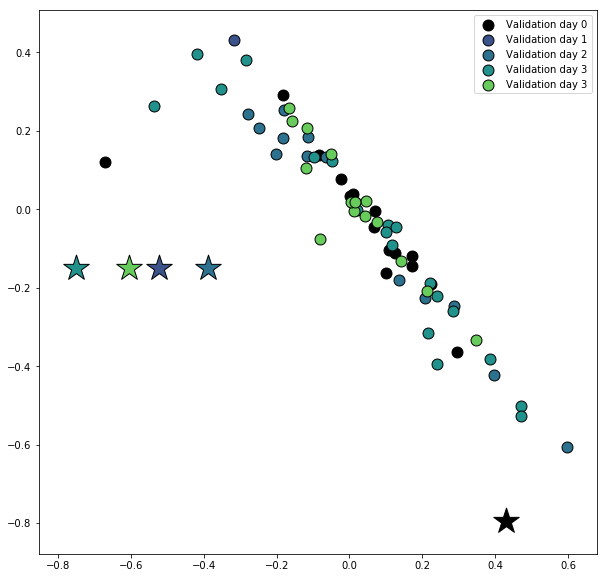

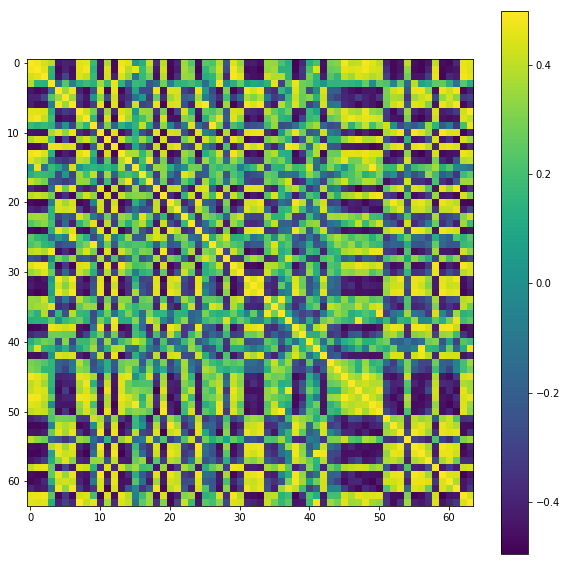

0

 distance from reference to day 0 spectral fingerprint = 0.00000e+00

 distance from reference to day 1 spectral fingerprint = 9.20855e+00

 distance from reference to day 2 spectral fingerprint = 7.25774e+00

 distance from reference to day 3 spectral fingerprint = 7.95563e+00

 distance from reference to day 4 spectral fingerprint = 8.29083e+00
learning rate decayed to 9.407945e-03 (classification) and 1.000000e-03 (autoencoding)
Training classification loss epoch 60 = 1.19446e+00, accuracy = 0.6875
Autoencoding loss epoch 60 = 1.01001e-04 
r^2 for AE = 9.923184043e-01
Elapsed time:  43.70223617553711  s
(5, 1798)
highest variance at  29
second highest variance activation =  53
(64,)


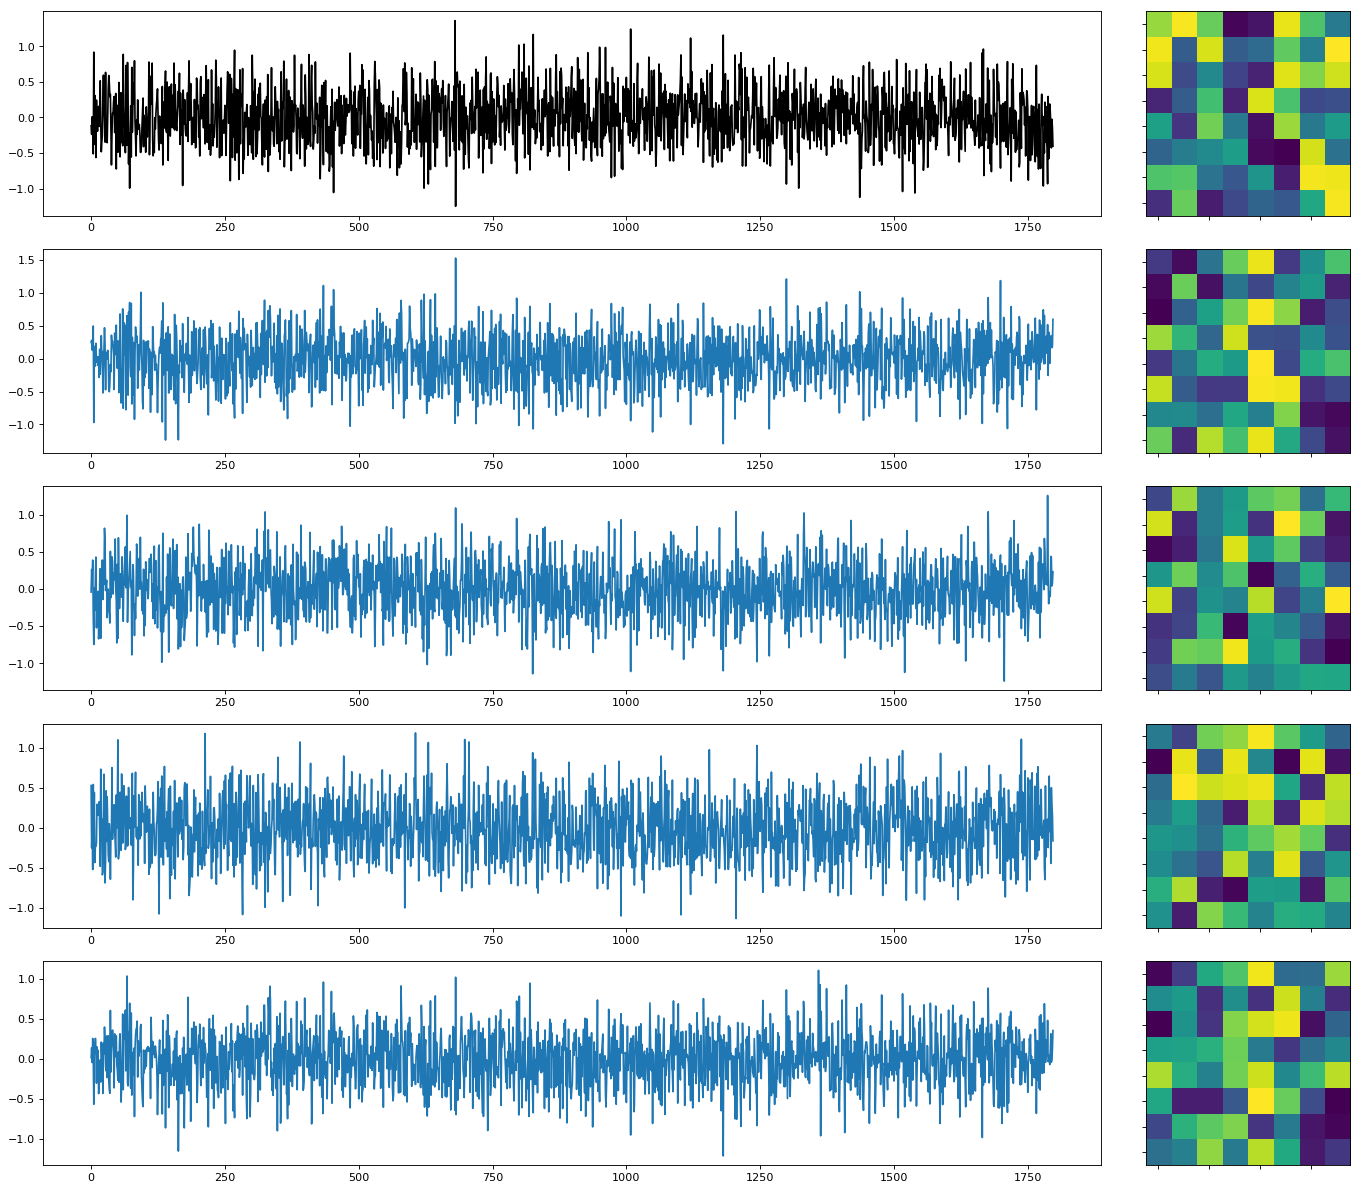

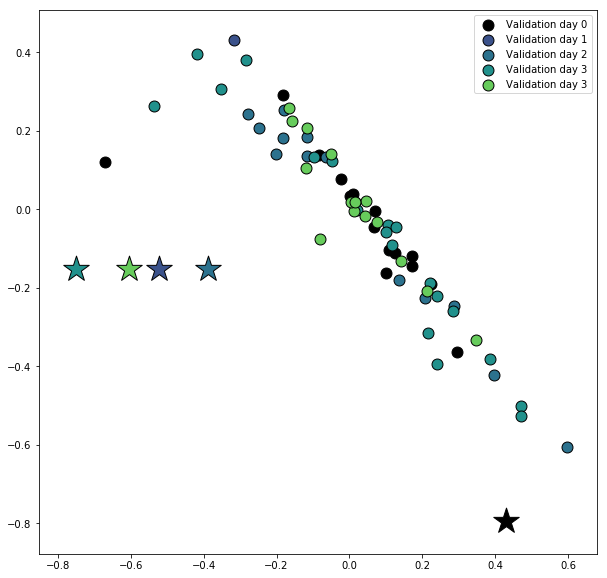

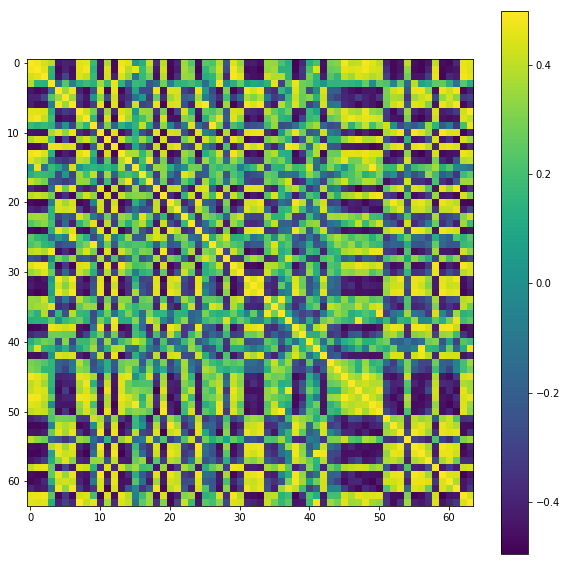

0

 distance from reference to day 0 spectral fingerprint = 0.00000e+00

 distance from reference to day 1 spectral fingerprint = 9.20866e+00

 distance from reference to day 2 spectral fingerprint = 7.25939e+00

 distance from reference to day 3 spectral fingerprint = 7.95347e+00

 distance from reference to day 4 spectral fingerprint = 8.29148e+00
learning rate decayed to 9.314288e-03 (classification) and 1.000000e-03 (autoencoding)
Training classification loss epoch 70 = 1.19446e+00, accuracy = 0.6875
Autoencoding loss epoch 70 = 1.01001e-04 
r^2 for AE = 9.923184043e-01
Elapsed time:  49.91591763496399  s
(5, 1798)
highest variance at  29
second highest variance activation =  53
(64,)


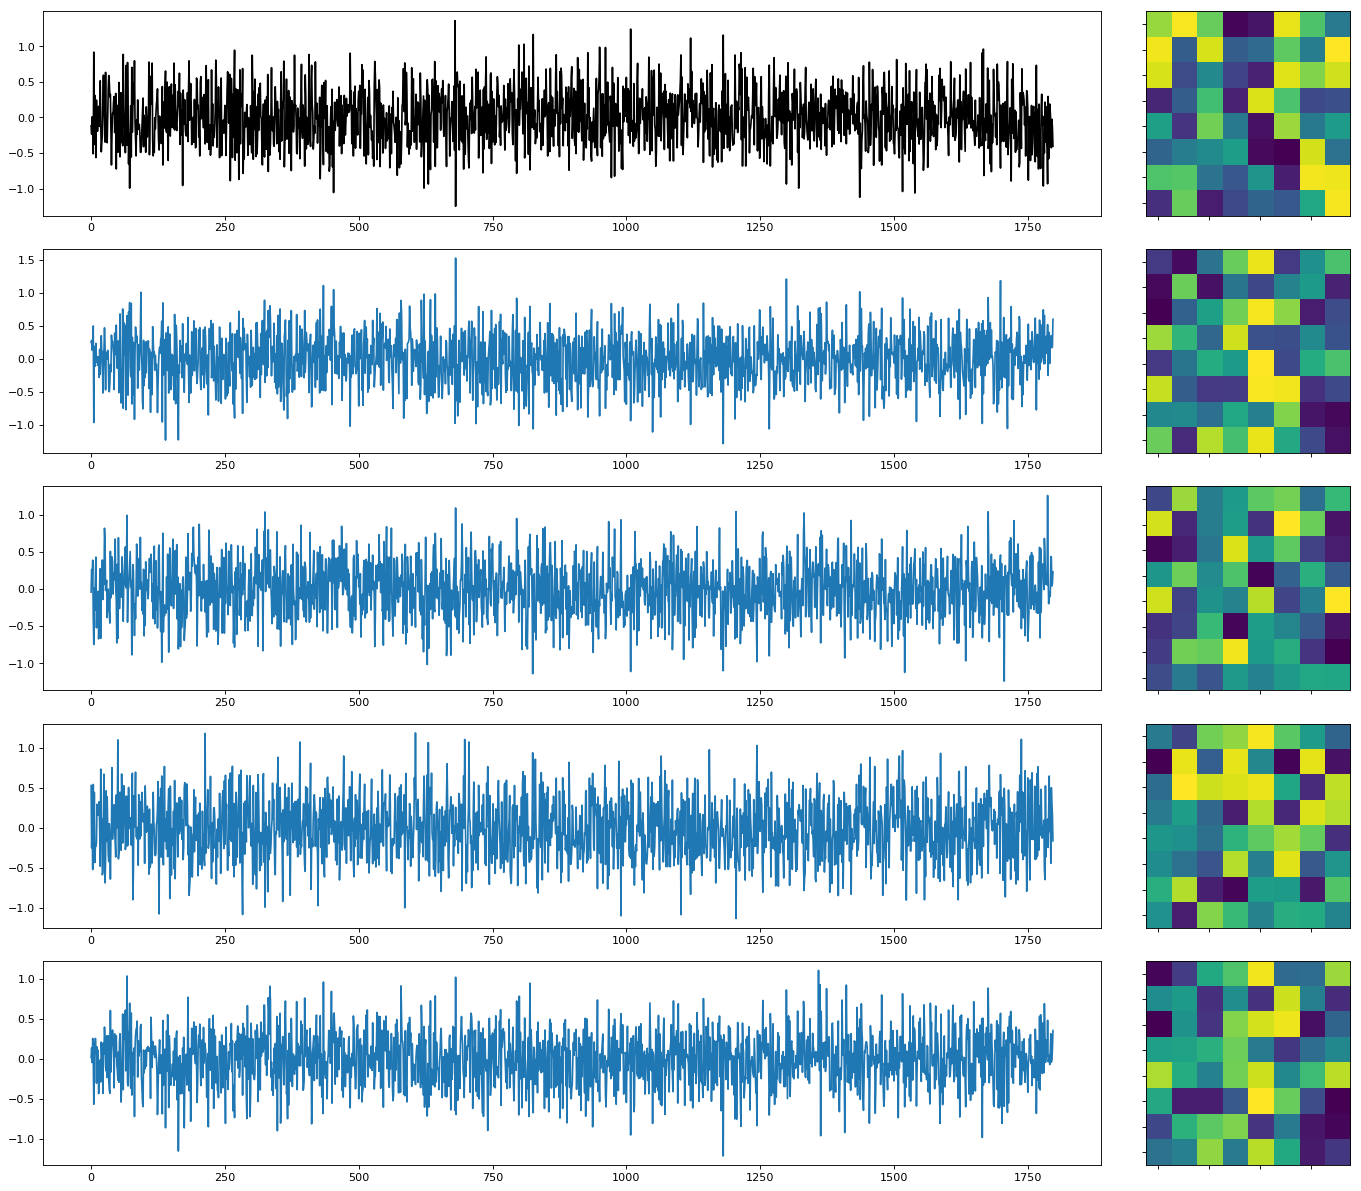

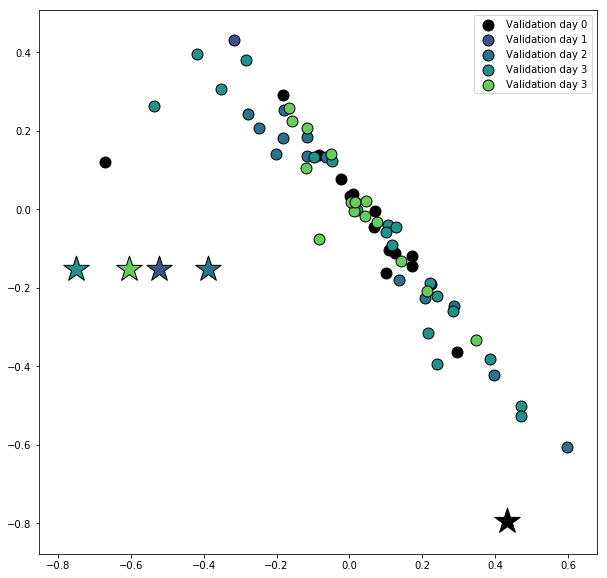

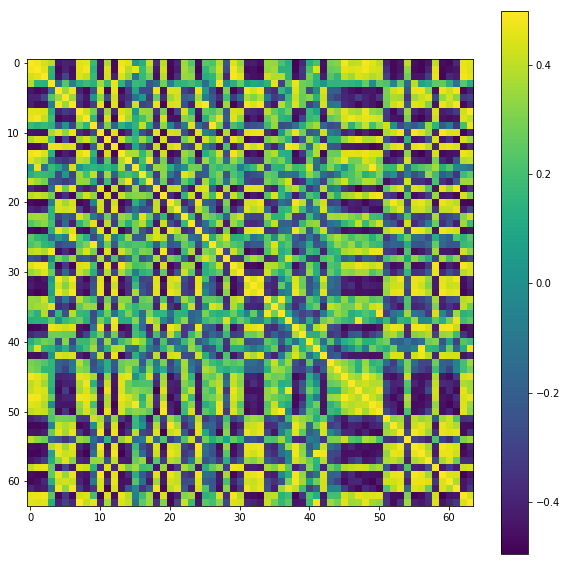

0

 distance from reference to day 0 spectral fingerprint = 0.00000e+00

 distance from reference to day 1 spectral fingerprint = 9.20885e+00

 distance from reference to day 2 spectral fingerprint = 7.26010e+00

 distance from reference to day 3 spectral fingerprint = 7.95157e+00

 distance from reference to day 4 spectral fingerprint = 8.29218e+00
learning rate decayed to 9.221563e-03 (classification) and 1.000000e-03 (autoencoding)
Training classification loss epoch 80 = 1.19446e+00, accuracy = 0.6875
Autoencoding loss epoch 80 = 1.01001e-04 
r^2 for AE = 9.923184043e-01
Elapsed time:  56.40832805633545  s
(5, 1798)
highest variance at  29
second highest variance activation =  53
(64,)


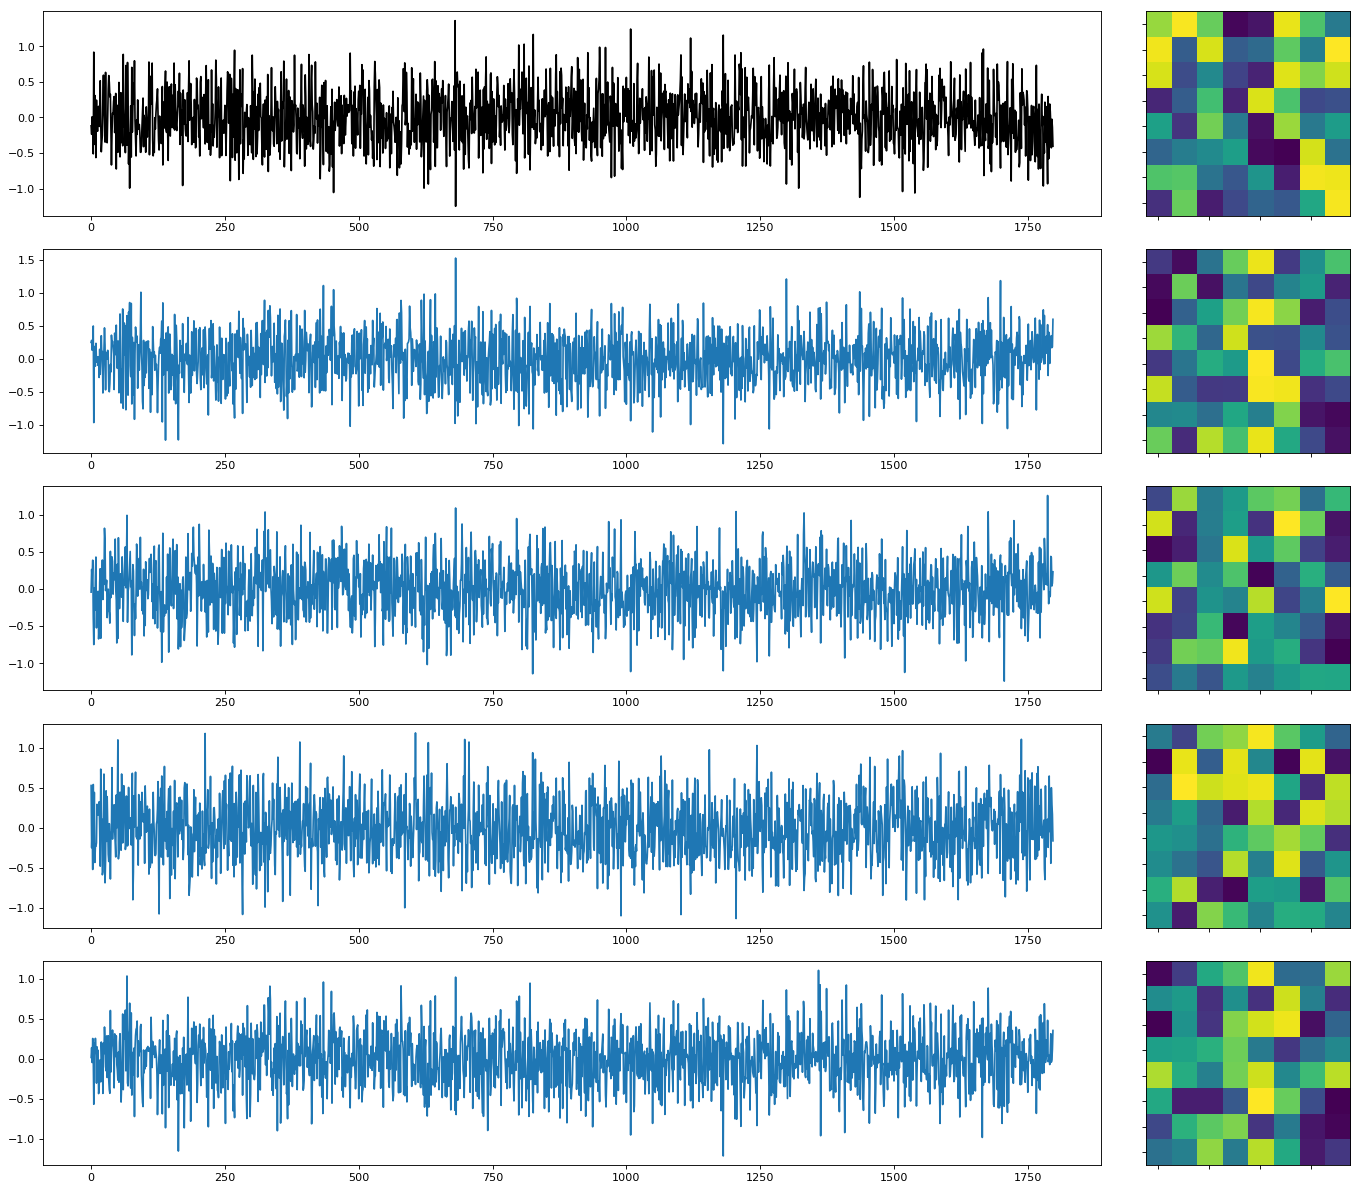

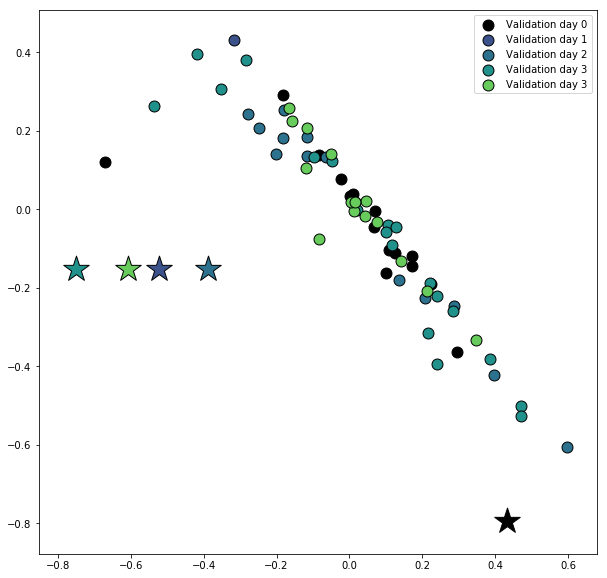

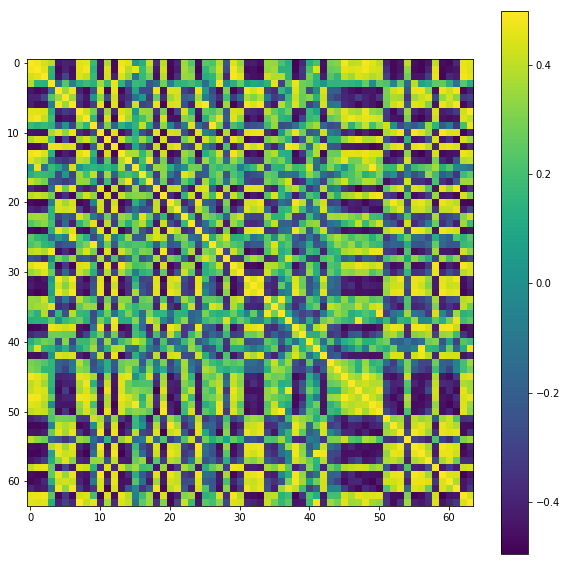

0

 distance from reference to day 0 spectral fingerprint = 0.00000e+00

 distance from reference to day 1 spectral fingerprint = 9.20894e+00

 distance from reference to day 2 spectral fingerprint = 7.26090e+00

 distance from reference to day 3 spectral fingerprint = 7.94993e+00

 distance from reference to day 4 spectral fingerprint = 8.29282e+00
learning rate decayed to 9.129761e-03 (classification) and 1.000000e-03 (autoencoding)
Training classification loss epoch 90 = 1.19445e+00, accuracy = 0.6875
Autoencoding loss epoch 90 = 1.01001e-04 
r^2 for AE = 9.923184043e-01
Elapsed time:  62.762139558792114  s
(5, 1798)
highest variance at  29
second highest variance activation =  53
(64,)


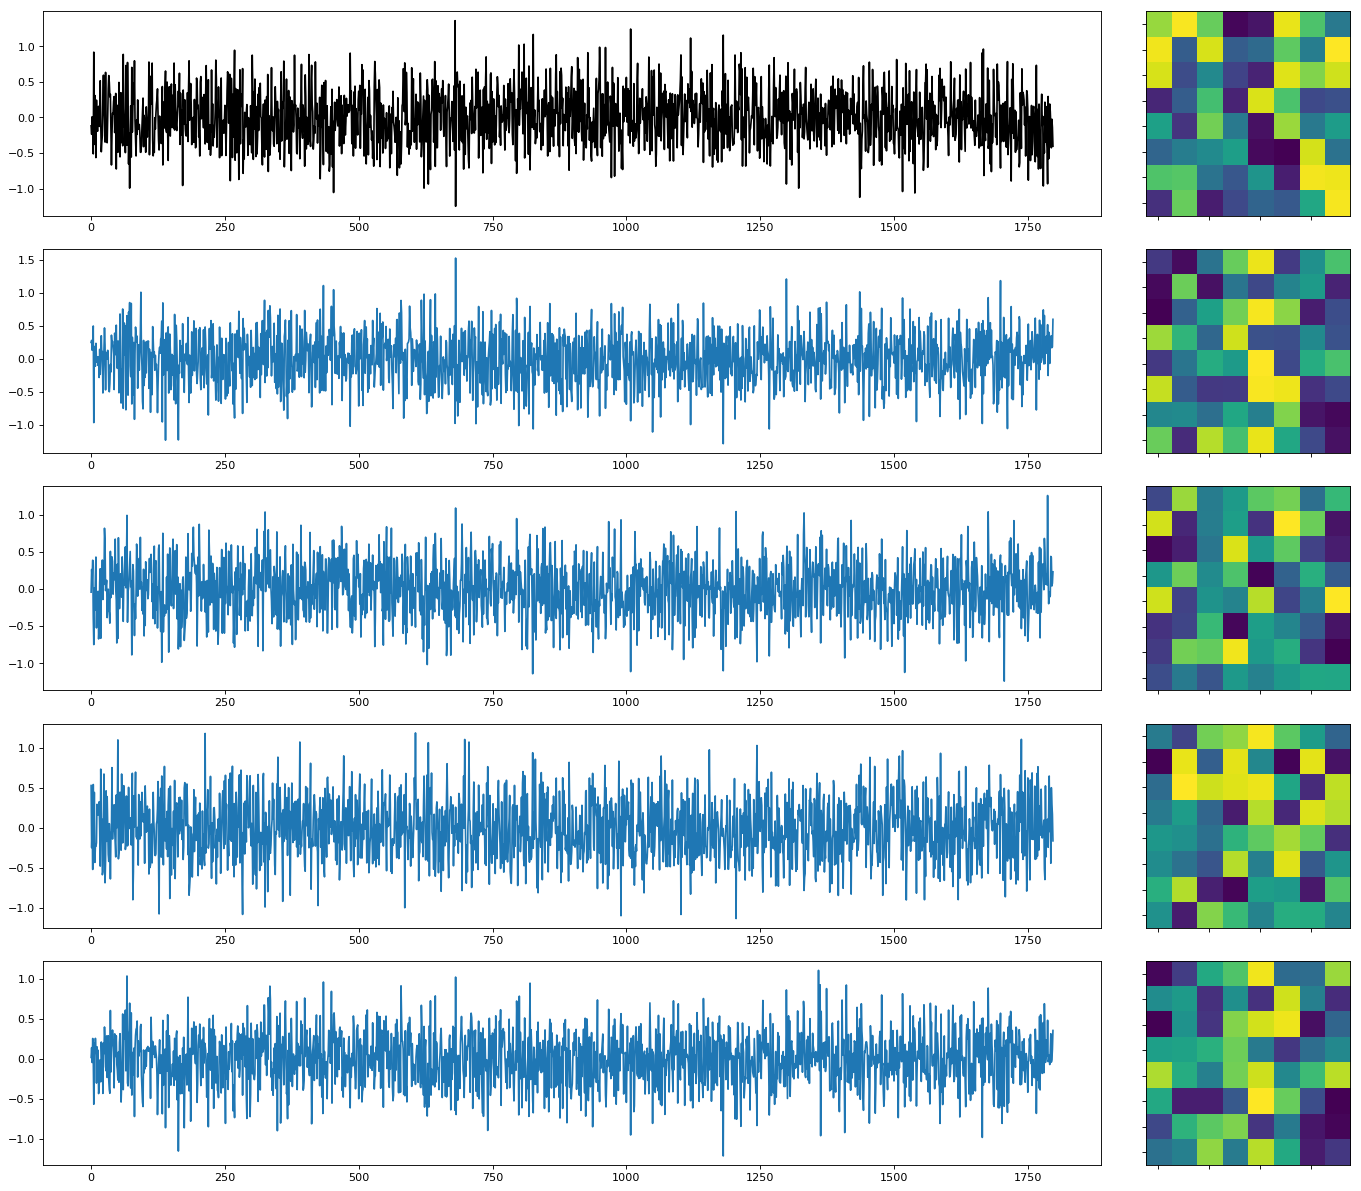

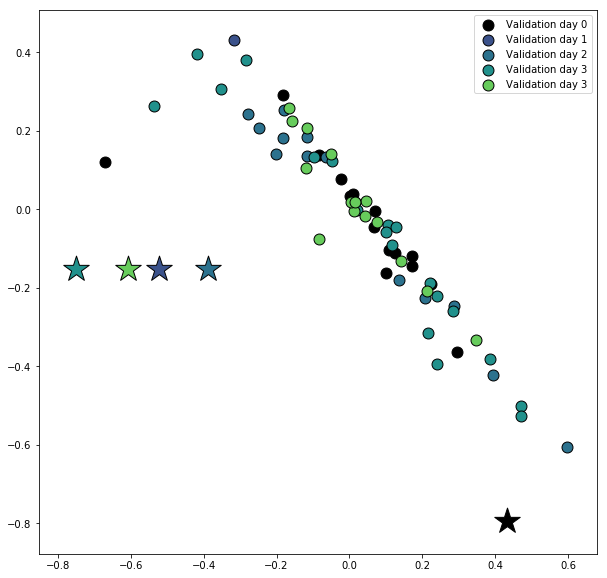

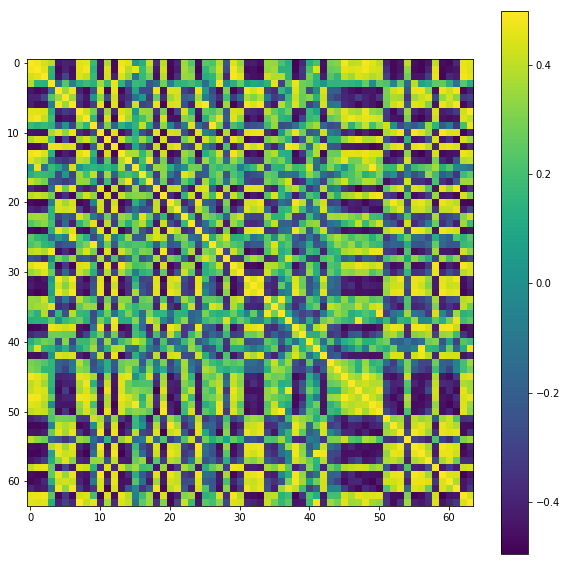

0

 distance from reference to day 0 spectral fingerprint = 0.00000e+00

 distance from reference to day 1 spectral fingerprint = 9.20885e+00

 distance from reference to day 2 spectral fingerprint = 7.26162e+00

 distance from reference to day 3 spectral fingerprint = 7.94847e+00

 distance from reference to day 4 spectral fingerprint = 8.29341e+00
learning rate decayed to 9.038874e-03 (classification) and 1.000000e-03 (autoencoding)
Training classification loss epoch 100 = 1.19445e+00, accuracy = 0.6875
Autoencoding loss epoch 100 = 1.01001e-04 
r^2 for AE = 9.923184043e-01
Elapsed time:  68.92205548286438  s
(5, 1798)
highest variance at  29
second highest variance activation =  53
(64,)


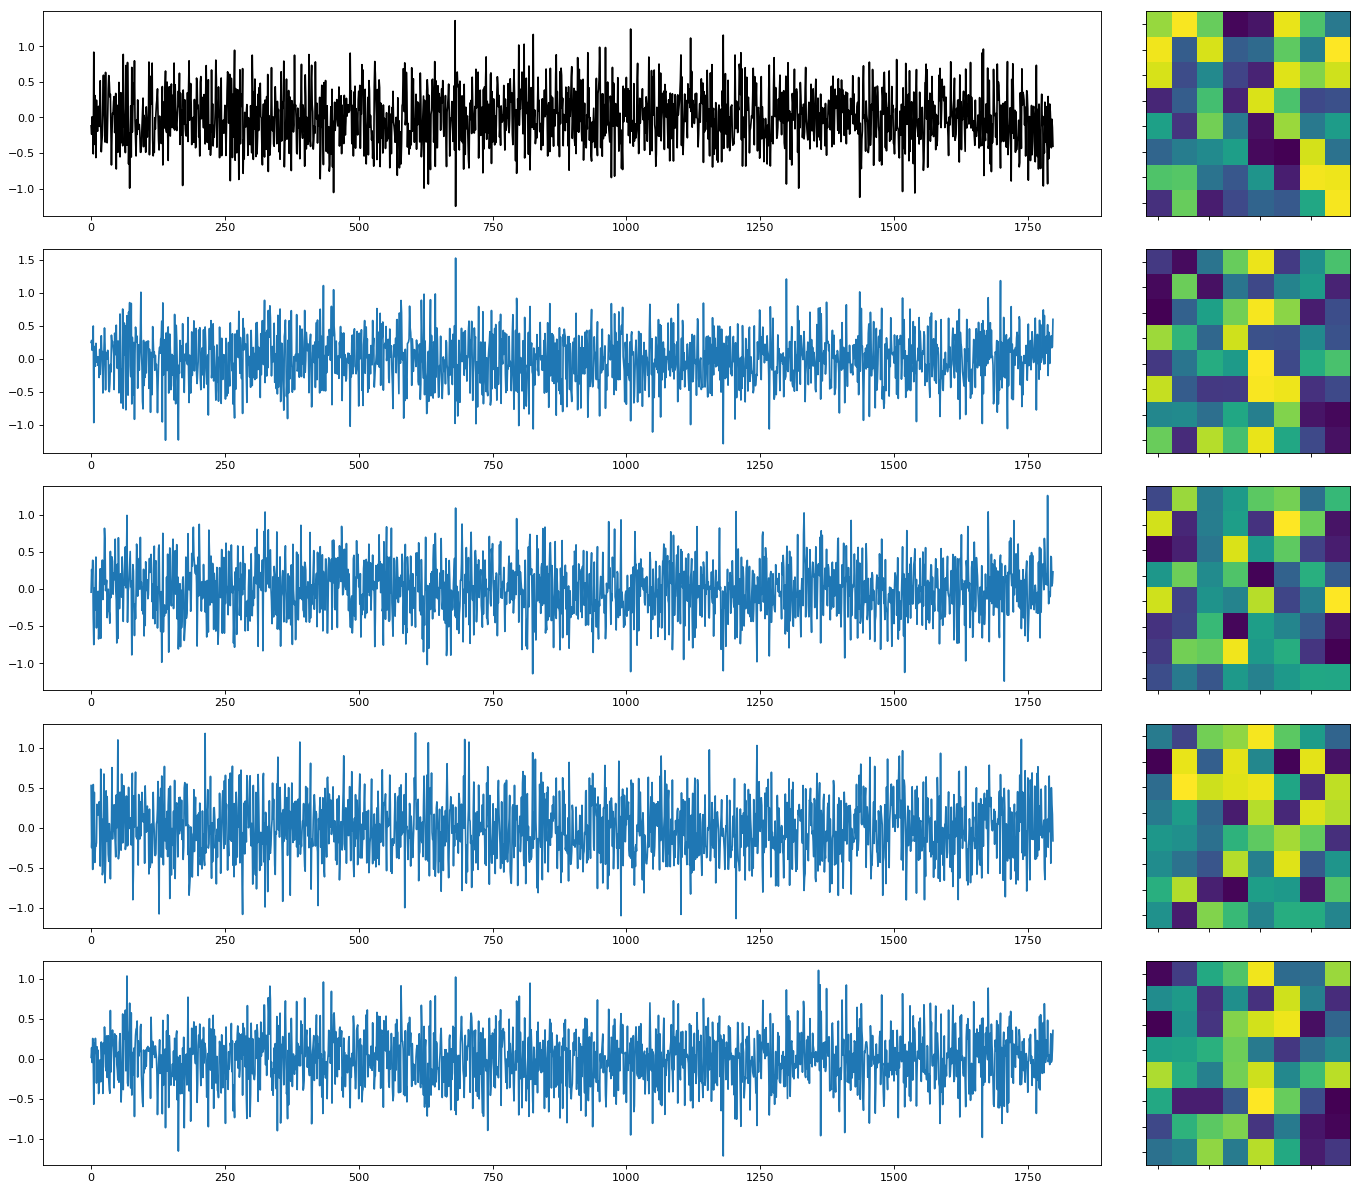

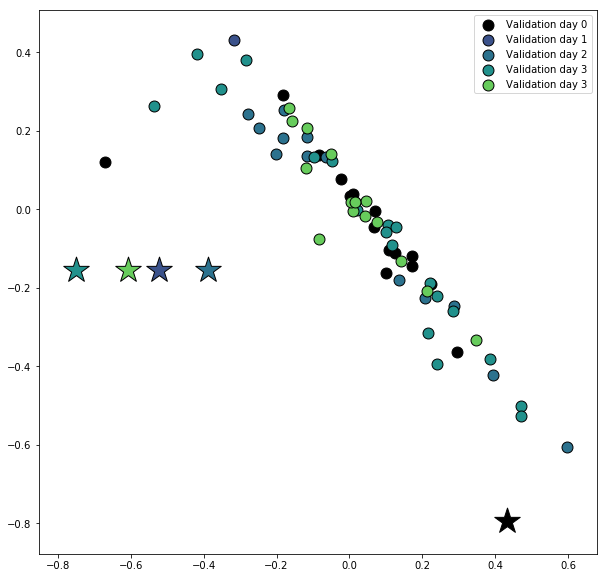

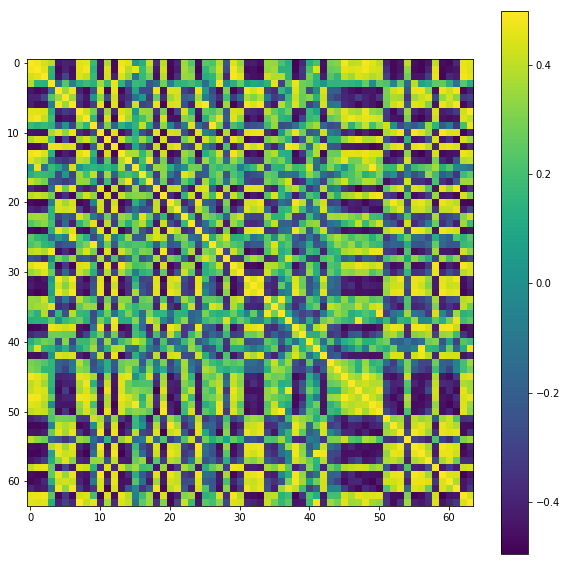

0

 distance from reference to day 0 spectral fingerprint = 0.00000e+00

 distance from reference to day 1 spectral fingerprint = 9.20867e+00

 distance from reference to day 2 spectral fingerprint = 7.26212e+00

 distance from reference to day 3 spectral fingerprint = 7.94718e+00

 distance from reference to day 4 spectral fingerprint = 8.29391e+00


In [65]:
def cMain():
    lRAE = 1e-3
    lRC = 1e-2
    epochs = 101
    dispIt = 10
    lrDecay = 1 - 1e-4
    
    
    t0 = time.time()
    cLosses = []
    aELosses = []
    
    with tf.Session() as sess:
        #tf.global_variables_initializer()
        tf.initialize_all_variables().run() # deprecated, but tf.global_variables_initializer doesn't work at all
        mySaverRaman.restore(sess,tf.train.latest_checkpoint('./models/doxo/'))
        for i in range(epochs):
            
            sess.run(cTrainOpFreeze, feed_dict = {inputs: X, classTargets: Y, myClasses: myClassess})
            #sess.run(aETrainOp, feed_dict = {inputs: trainX, classTargets: trainY, myClasses: myClassess})
            cLosses.append(sess.run(cLoss, feed_dict = {inputs: trainX, classTargets: trainY, myClasses: myClassess}))
            #print(lRAE)
            #lRAE = lRAE * lRDecay
            lRC = lRC * lRDecay
            if (i % dispIt == 0):
                print("learning rate decayed to %e (classification) and %e (autoencoding)" % (lRC,lRAE))
                recons = sess.run(myRecon, feed_dict = {inputs: testX, classTargets: testY, myClasses: myClassess})
                preds = sess.run(myPred, feed_dict = {inputs: testX, classTargets: testY, myClasses: myClassess})
                codes = sess.run(myCode,  feed_dict = {inputs: trainX, classTargets: trainY, myClasses: myClassess})
                #print(np.shape(recon))
                myAccuracy = evalAcc(testY,preds)

                print("Training classification loss epoch %i = %.5e, accuracy = %.4f" % (i,np.mean(sess.run(cLoss, feed_dict={inputs: X, classTargets: Y, myClasses: myClassess})),myAccuracy))
                print("Autoencoding loss epoch %i = %.5e " % (i,np.mean(sess.run(aELoss, feed_dict={inputs: X, classTargets: Y, myClasses: myClassess}))))
                np.shape(preds)
                myR2RamanAE = r2(testX,recons)
                print("r^2 for AE = %.9e" %myR2RamanAE)
                elapsed = time.time() - t0
                print("Elapsed time: ", elapsed, " s")
                
                codes0 = sess.run(myCode,  feed_dict = {inputs: testDay0, classTargets: testDay0Y, myClasses: myClassess})
                codes1 = sess.run(myCode,  feed_dict = {inputs: testDay1, classTargets: testDay1Y, myClasses: myClassess})
                codes2 = sess.run(myCode,  feed_dict = {inputs: testDay2, classTargets: testDay2Y, myClasses: myClassess})
                codes3 = sess.run(myCode,  feed_dict = {inputs: testDay3, classTargets: testDay3Y, myClasses: myClassess})
                codes4 = sess.run(myCode,  feed_dict = {inputs: testDay4, classTargets: testDay4Y, myClasses: myClassess})
                  
                
                myGe = sess.run(myGen,  feed_dict = {inputs: testX, classTargets: testY, myClasses: myClassess})
                print(np.shape(myGe))
                myYs = [[1,0,0,0,0],[0,1,0,0,0],[0,0,1,0,0],[0,0,0,1,0],[0,0,0,0,1]]
                
                dayCodes = sess.run(myCode, feed_dict = {inputs: myGe,classTargets: myYs, myClasses: myClassess}) #myCode,  feed_dict = {inputs: testDay0, classTargets: testDay0Y, myClasses: myClassess})
                
                figC = plt.figure(figsize=(18,15),dpi=80) #(5, 3, figsize=(18, 15),dpi=80)
                gs = gridspec.GridSpec(5, 2, width_ratios=[3, 1]) 
                
                ax0 = plt.subplot(gs[0,0])
                ax0.plot(myGe[0],color='k')
                ax1 = plt.subplot(gs[1,0])
                ax1.plot(myGe[1])
                ax2 = plt.subplot(gs[2,0])
                ax2.plot(myGe[2])
                ax3 = plt.subplot(gs[3,0])
                ax3.plot(myGe[3])
                ax4 = plt.subplot(gs[4,0])
                ax4.plot(myGe[4])
                
                ax01 = plt.subplot(gs[0,1])
                ax01.imshow(np.reshape(dayCodes[0],[8,8]))
                ax11 = plt.subplot(gs[1,1])
                ax11.imshow(np.reshape(dayCodes[1],[8,8]))
                ax21 = plt.subplot(gs[2,1])
                ax21.imshow(np.reshape(dayCodes[2],[8,8]))
                ax31 = plt.subplot(gs[3,1])
                ax31.imshow(np.reshape(dayCodes[3],[8,8]))
                ax41 = plt.subplot(gs[4,1])
                ax41.imshow(np.reshape(dayCodes[4],[8,8]))
                ax41.set_xticklabels('')
                ax41.set_yticklabels('')
                ax31.set_xticklabels('')
                ax31.set_yticklabels('')
                ax21.set_xticklabels('')
                ax21.set_yticklabels('')
                ax11.set_xticklabels('')
                ax11.set_yticklabels('')
                ax01.set_xticklabels('')
                ax01.set_yticklabels('')
                
                
                plt.tight_layout()
                #plt.show()
                mySaverRaman.save(sess,'./models/doxo/',global_step=i)
               
                print('highest variance at ',np.argmax(np.var(codes,axis=0)))
                axisX = np.argmax(np.var(codes,axis=0))
                codes_2 = np.copy(codes)
                #axisY = axisX
                codes_2[:,axisX]  = 0
                axisY = np.argmax(np.var(codes_2,axis=0))
                print('second highest variance activation = ', axisY)
                print(np.shape(np.var(codes,axis=0)))
                plt.figure(figsize=(10,10))
                scatX = codes[:,axisX]
                scatY = codes[:,axisY]
                
                markerSize = 720
                
                if (1):
                    plt.scatter(dayCodes[0,axisX],dayCodes[0,axisY],s=markerSize,marker='*',color='k',edgecolors='k')
                    plt.scatter(codes0[:,axisX],codes0[:,axisY],s=markerSize/6,color='k',edgecolors='k',label='Validation day 0')

                    plt.scatter(dayCodes[1,axisX],dayCodes[4,axisY],s=markerSize,marker='*',color=C2,edgecolors='k')
                    plt.scatter(codes1[:,axisX],codes1[:,axisY],s=markerSize/6,color=C2,edgecolors='k',label='Validation day 1')

                    plt.scatter(dayCodes[2,axisX],dayCodes[4,axisY],s=markerSize,marker='*',color=C3,edgecolors='k')
                    plt.scatter(codes2[:,axisX],codes2[:,axisY],s=markerSize/6,color=C3,edgecolors='k',label='Validation day 2')

                    plt.scatter(dayCodes[3,axisX],dayCodes[4,axisY],s=markerSize,marker='*',color=C4,edgecolors='k')
                    plt.scatter(codes3[:,axisX],codes3[:,axisY],s=markerSize/6,color=C4,edgecolors='k',label='Validation day 3')

                    plt.scatter(dayCodes[4,axisX],dayCodes[4,axisY],s=markerSize,marker='*',color=C5,edgecolors='k')
                    plt.scatter(codes4[:,axisX],codes4[:,axisY],s=markerSize/6,color=C5,edgecolors='k',label='Validation day 3')

                    plt.legend()
        #plt.figure()
                #plt.imshow(np.reshape(np.var(codes,axis=0),[8,8]))
                myCors = np.zeros((64,64))
                for c in range(64):
                    for k in range(64):
                        myCors[c,k] = np.mean(pearsonr(codes[:,c],codes[:,k]))
                        
                plt.figure(figsize=(10,10))
                plt.imshow(myCors)
                plt.colorbar()
                plt.show()
                print(np.argmax(myCors))
                for c in range(5):
                    myTestDist = calcDist(dayCodes[0],dayCodes[c])
                    
                    print('\n distance from reference to day %i spectral fingerprint = %.5e'%(c,myTestDist))
                
cMain()

In [64]:
help(pearsonr)

Help on function pearsonr in module scipy.stats.stats:

pearsonr(x, y)
    Calculates a Pearson correlation coefficient and the p-value for testing
    non-correlation.
    
    The Pearson correlation coefficient measures the linear relationship
    between two datasets. Strictly speaking, Pearson's correlation requires
    that each dataset be normally distributed, and not necessarily zero-mean.
    Like other correlation coefficients, this one varies between -1 and +1
    with 0 implying no correlation. Correlations of -1 or +1 imply an exact
    linear relationship. Positive correlations imply that as x increases, so
    does y. Negative correlations imply that as x increases, y decreases.
    
    The p-value roughly indicates the probability of an uncorrelated system
    producing datasets that have a Pearson correlation at least as extreme
    as the one computed from these datasets. The p-values are not entirely
    reliable but are probably reasonable for datasets larger than 

In [12]:
def calcDist(code1,code2):
    if not(len(code1 == code2 )):
        print('error, lengths do not match')
        return 0
    myDistTemp = 0
    for ck in range(len(code1)):
        myDistTemp = myDistTemp + (code1[ck]-code2[ck])**2
    myDist = np.sqrt(myDistTemp)
    return myDist

#for c in range(5):
#    myTestDist = calcDist(dayCodes[c],dayCodes[c])
#    print(myTestDist)

In [ ]:
def projMain():
    epochs = 100
    dispIt = 10
    lR = 1e-4
    with tf.Session() as sess:
        #tf.global_variables_initializer()
        tf.initialize_all_variables().run() # deprecated, but tf.global_variables_initializer doesn't work at all
        mySaverRaman.restore(sess,tf.train.latest_checkpoint('./models/doxo/'))
        for i in range(epochs):
            
            if (i % dispIt == 0):
                trainCodes = sess.run(myCode,  feed_dict = {inputs: trainX, classTargets: trainY, myClasses: myClassess})
                
projMain()

Instructions for updating:
Use `tf.global_variables_initializer` instead.
INFO:tensorflow:Restoring parameters from ./models/doxo/-0
learning rate decayed to 1.000000e-03 (classification) and 9.990000e-04 (autoencoding)
Error (shapes don't match)
Training classification loss epoch 0 = 1.19449e+00, accuracy = 0.0000


/home/main/anaconda3/envs/lV/lib/python3.6/site-packages/ipykernel_launcher.py:33: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


Autoencoding loss epoch 0 = 1.05876e-04 
r^2 for AE = 9.920686385e-01
Elapsed time:  1.4625816345214844  s


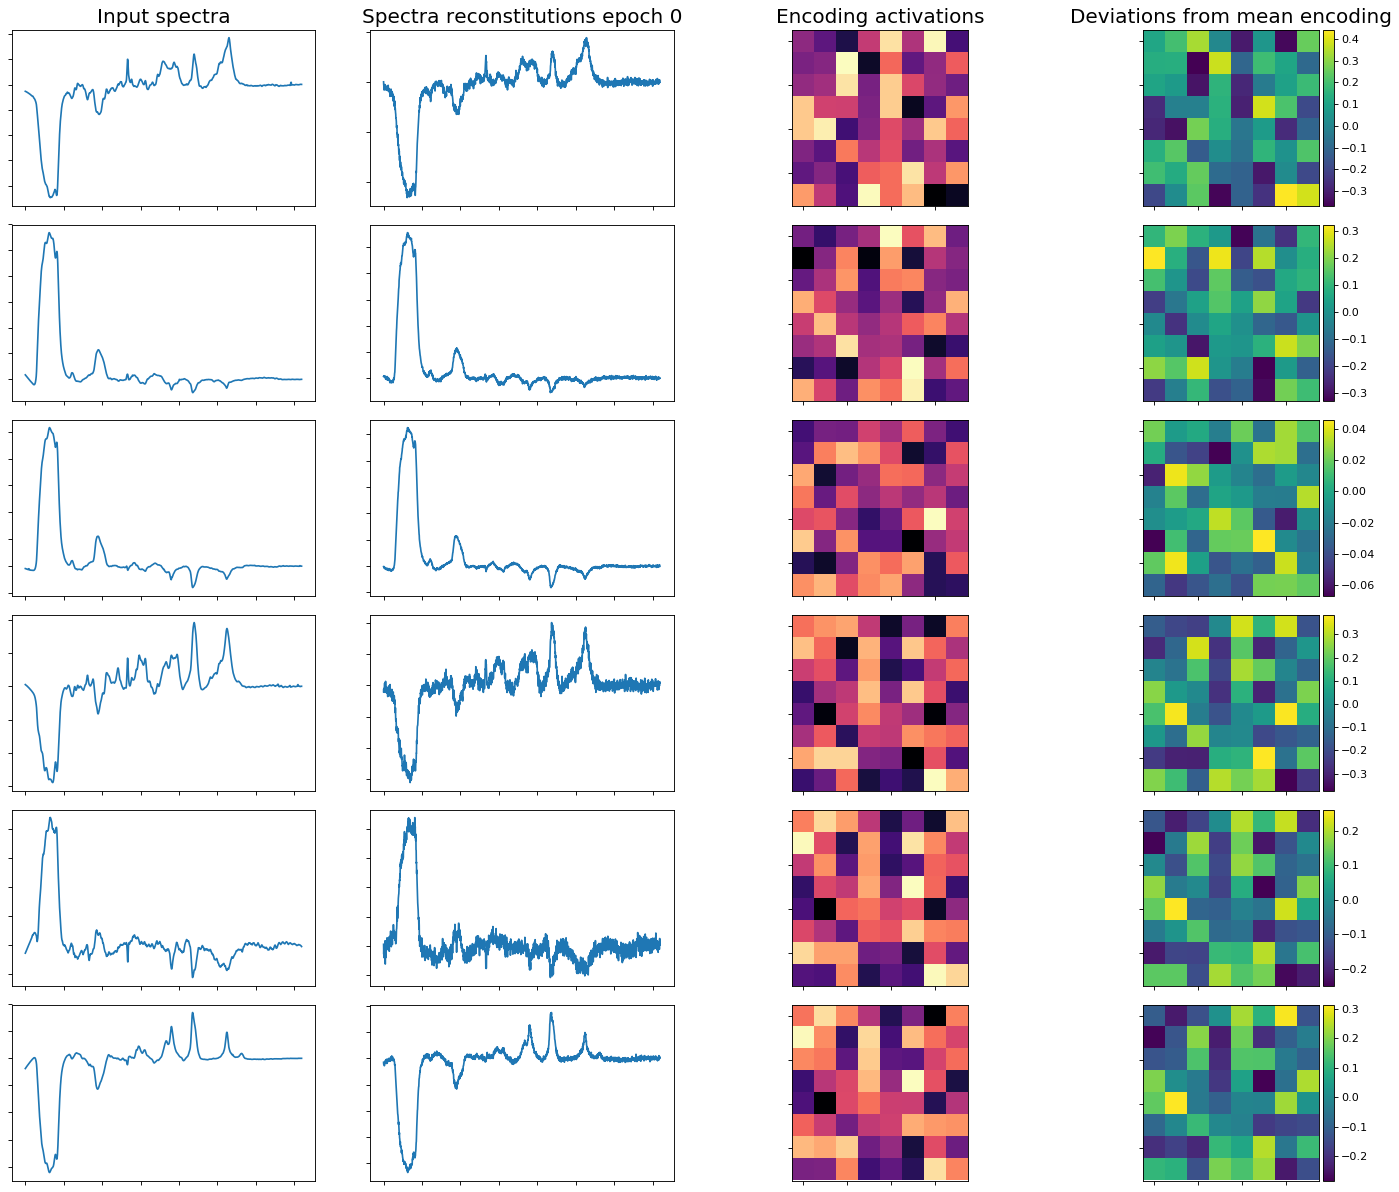

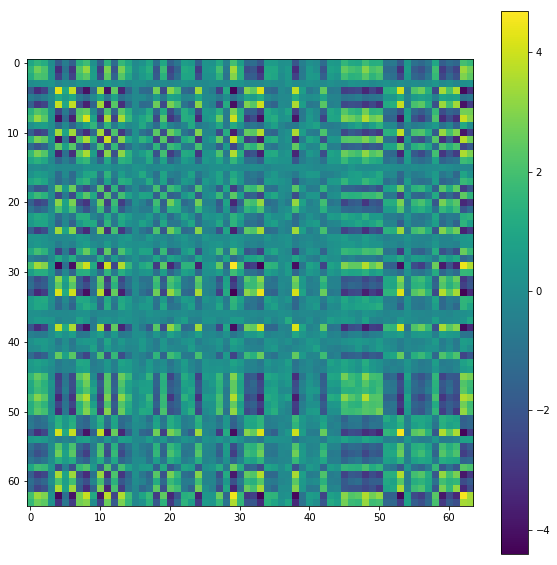

1885
learning rate decayed to 1.000000e-03 (classification) and 3.673277e-04 (autoencoding)
Error (shapes don't match)
Training classification loss epoch 1000 = 1.19548e+00, accuracy = 0.0000
Autoencoding loss epoch 1000 = 1.01001e-04 
r^2 for AE = 9.923184043e-01
Elapsed time:  285.28341579437256  s


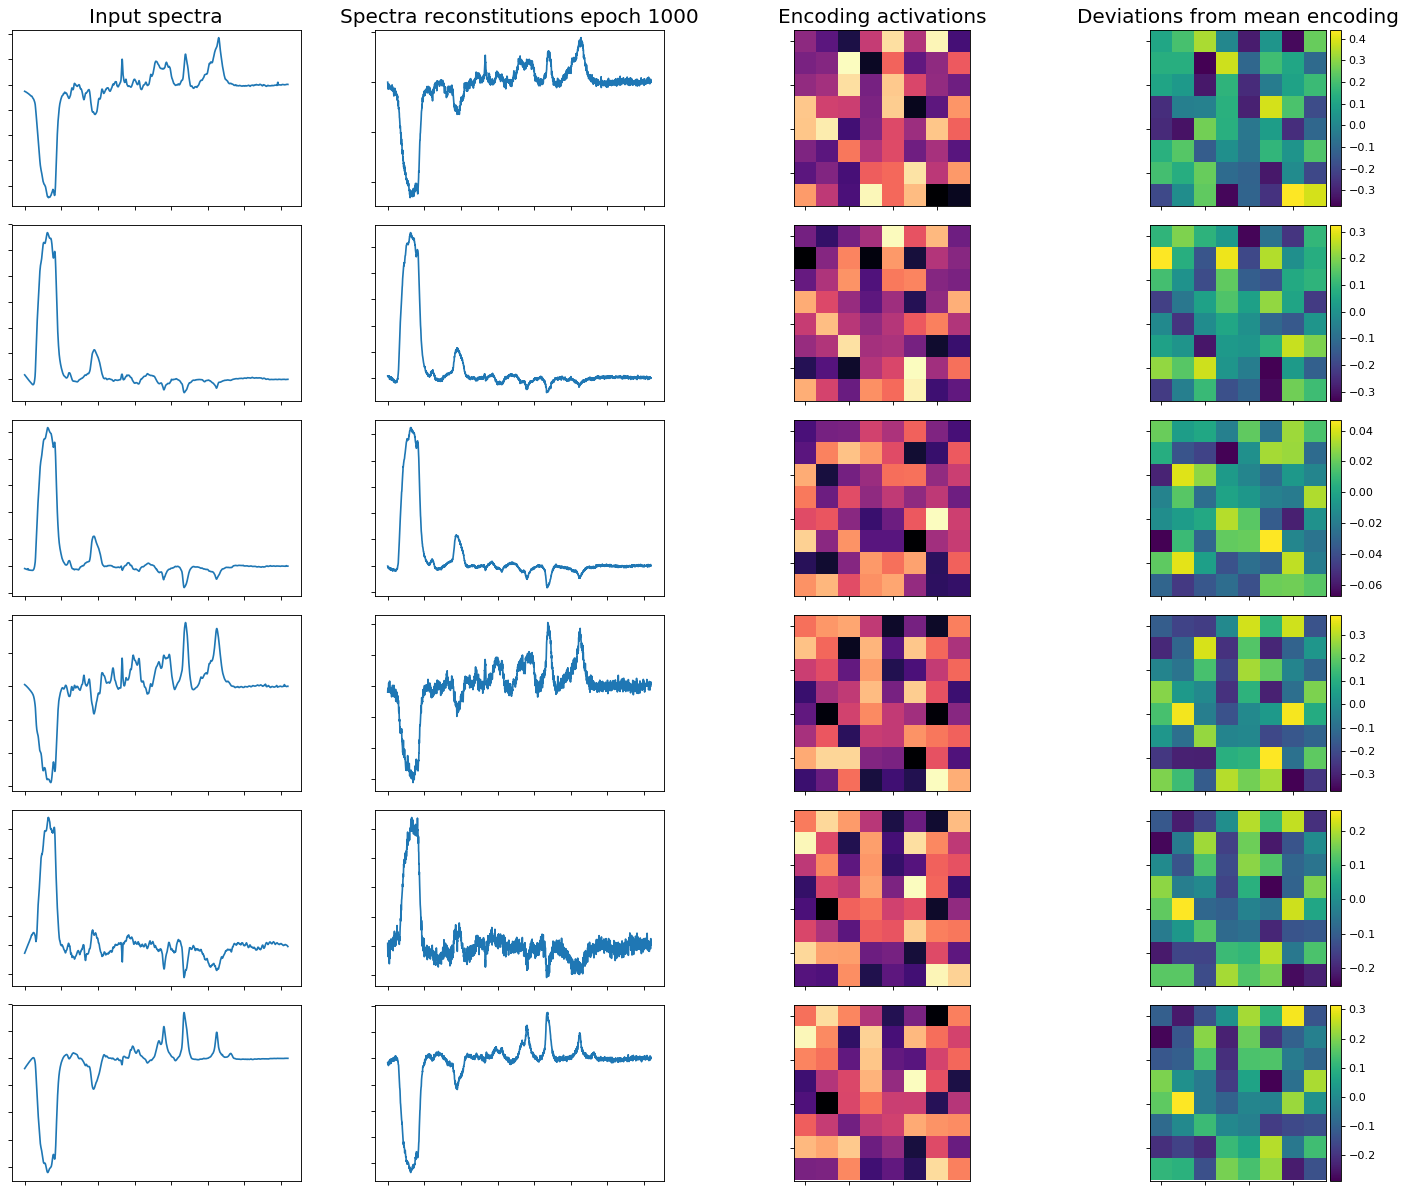

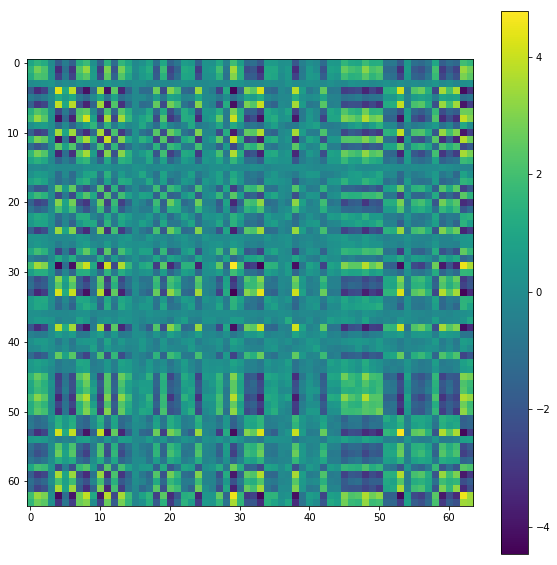

1885


KeyboardInterrupt: 

In [58]:
def AEMain():
    lRAE = 1e-3
    lRC = 1e-3
    epochs = 1001
    dispIt = 100
    lrDecay = 1 - 1e-4
    
    
    t0 = time.time()
    cLosses = []
    aELosses = []
    
    with tf.Session() as sess:
        #tf.global_variables_initializer()
        tf.initialize_all_variables().run() # deprecated, but tf.global_variables_initializer doesn't work at all
        mySaverRaman.restore(sess,tf.train.latest_checkpoint('./models/doxo/'))
        for i in range(epochs):
            
            #sess.run(cTrainOp, feed_dict = {inputs: X, classTargets: Y, myClasses: myClassess})
            sess.run(aETrainOp, feed_dict = {inputs: trainX, classTargets: trainY, myClasses: myClassess})
            aELosses.append(sess.run(aELoss, feed_dict = {inputs: trainX, classTargets: trainY, myClasses: myClassess}))
            #print(lRAE)
            lRAE = lRAE * lRDecay
            #lRC = lRC * lRDecay
            if (i % dispIt == 0):
                print("learning rate decayed to %e (classification) and %e (autoencoding)" % (lRC,lRAE))
                recons = sess.run(myRecon, feed_dict = {inputs: testX, classTargets: testY, myClasses: myClassess})
                preds = sess.run(myPred, feed_dict = {inputs: trainX, classTargets: trainY, myClasses: myClassess})
                codes = sess.run(myCode,  feed_dict = {inputs: trainX, classTargets: trainY, myClasses: myClassess})
                #print(np.shape(recon))
                myAccuracy = evalAcc(Y,preds)

                print("Training classification loss epoch %i = %.5e, accuracy = %.4f" % (i,np.mean(sess.run(cLoss, feed_dict={inputs: X, classTargets: Y, myClasses: myClassess})),myAccuracy))
                print("Autoencoding loss epoch %i = %.5e " % (i,np.mean(sess.run(aELoss, feed_dict={inputs: X, classTargets: Y, myClasses: myClassess}))))
                
                myR2RamanAE = r2(testX,recons)
                print("r^2 for AE = %.9e" %myR2RamanAE)
                elapsed = time.time() - t0
                print("Elapsed time: ", elapsed, " s")
                
                fig, axs = plt.subplots(6, 4, figsize=(18, 15),dpi=80)
                #plt.figure()
                #plt.subplot(311)
                myMeanCodes = np.mean(codes,axis=0)
                im = []
                from mpl_toolkits.axes_grid1 import make_axes_locatable
                for myInd in range(6):
                    axs[myInd][0].plot(testX[12*myInd,...])
                    #plt.subplot(312)
                    axs[myInd][1].plot(recons[12*myInd,...])
                    #plt.subplot(313)
                    axs[myInd][2].imshow(np.reshape(codes[12*myInd,...],[8,8]),cmap='magma',interpolation='nearest')

                    im.append(axs[myInd][3].imshow(np.reshape(myMeanCodes-codes[12*myInd,...],[8,8]),cmap='viridis',interpolation='nearest'))
                    divider = make_axes_locatable(axs[myInd][3])
                    cax = divider.append_axes('right',size='6%',pad=0.05)
                    fig.colorbar(im[myInd],cax=cax) #axs[myInd][3])
                    for myCol in range(4):
                        axs[myInd,myCol].set_xticklabels('')
                        axs[myInd,myCol].set_yticklabels('')
                mySaverRaman.save(sess,'./models/doxo/',global_step=i)
                #mySaverRaman.save(sess,'.models/prostate',global_step=i)
                #plt.show()
                axs[0][2].set_title('Encoding activations',fontsize=18)
                axs[0][3].set_title('Deviations from mean encoding',fontsize=18)
                axs[0][1].set_title('Spectra reconstitutions epoch %i' %i,fontsize=18)
                axs[0][0].set_title('Input spectra',fontsize=18)
                plt.tight_layout()
                plt.show()
                myCors = np.zeros((64,64))
                for c in range(64):
                    for k in range(64):
                        myCors[c,k] = np.correlate(codes[:,c],codes[:,k])
                        
                plt.figure(figsize=(10,10))
                plt.imshow(myCors)
                plt.colorbar()
                plt.show()
                print(np.argmax(myCors))
                
AEMain()

In [61]:
np.sqrt(1884)

43.405068828421413

(64, 1798)
shape of myXRamanTrain (92, 64)


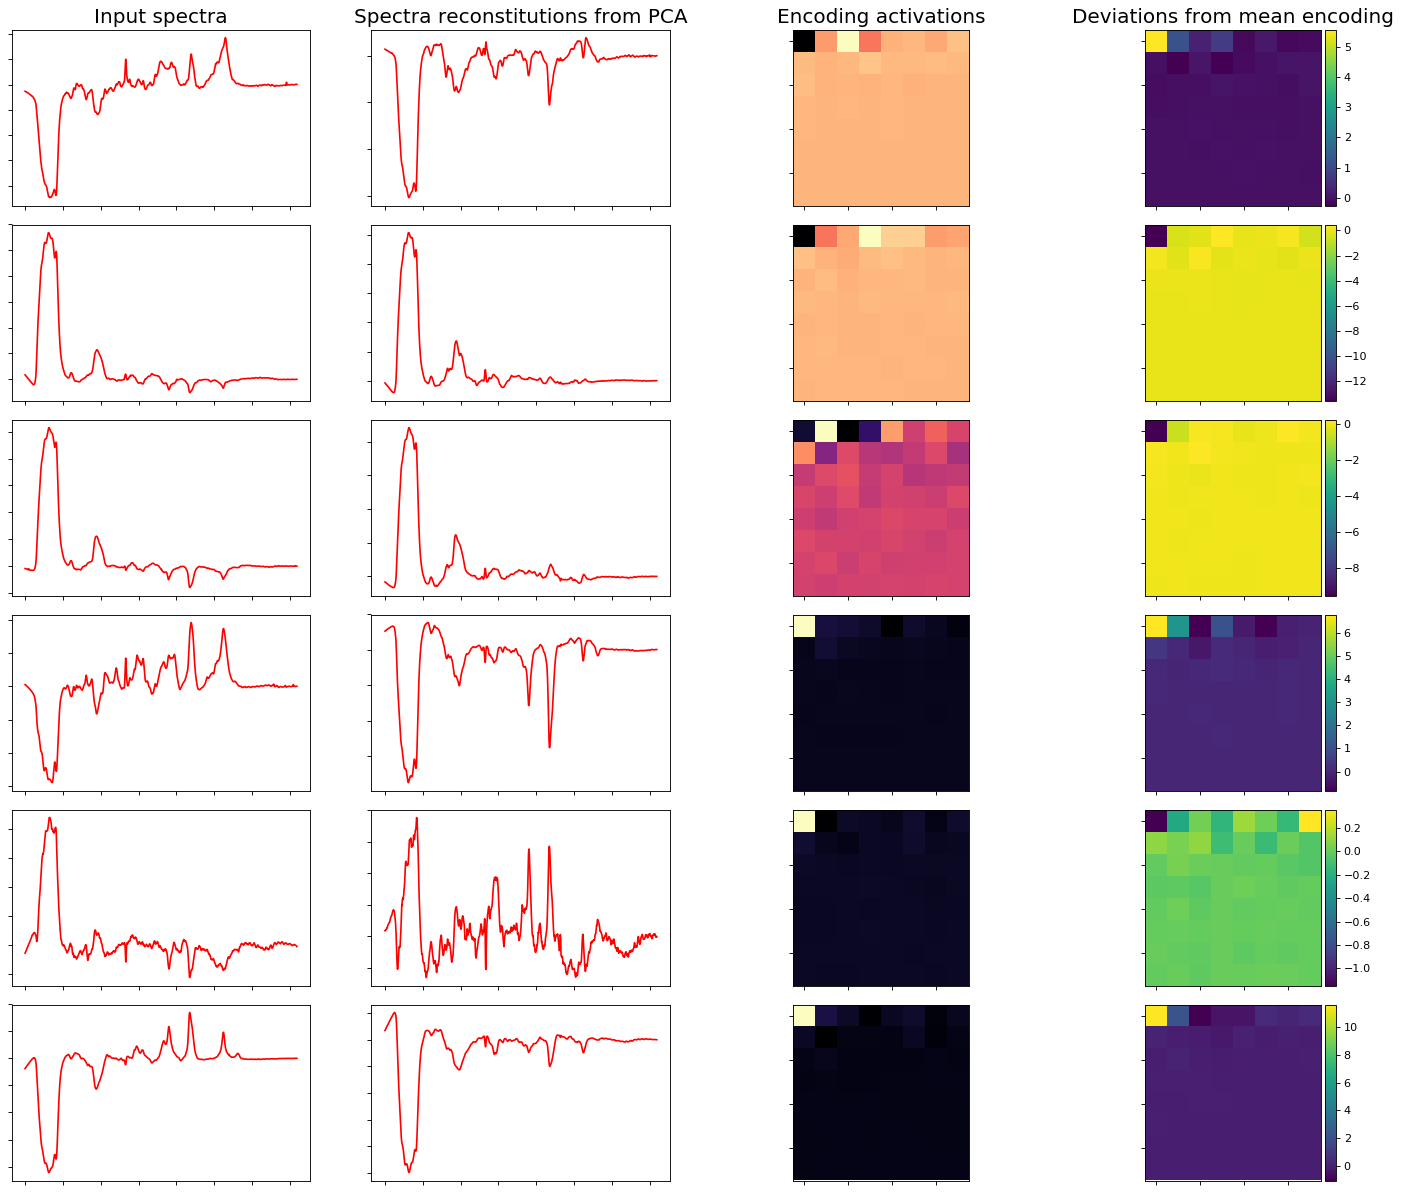

r^2 for PCA = 8.317971782e-01


In [21]:
dataLen = np.shape(trainX)[0]
testLen = round(dataLen*0.3)
trainLen = dataLen-testLen
rounds = 1
#can only have as many PCs as samples
#k = testLen
k = 5# S. Corsetti used 5 PCs
myBestPCALDAMetrics = np.zeros((rounds,6))
#for ldaComp in range(75):
ldaComp = 5
PCAComp = 64
myDispPCX = 8
myDispPCY = 8
for myFold in range(rounds):
    #Resample the sample set
    #np.random.seed(myFold)
    #np.random.shuffle(trainX)
    #np.random.seed(myFold)
    #np.random.shuffle(trainY)


    

    #print(np.shape(trainXDP),np.shape(testXDP))
    myPCARaman = sklearn.decomposition.PCA(n_components=PCAComp,iterated_power=1)#myHLCode)
    myFitRaman = myPCARaman.fit(trainX)
    #print(myFitRaman.explained_variance_ratio_)
    # Transform
    myXRaman = myFitRaman.fit_transform(testX)
    myXRamanTrain = myFitRaman.fit_transform(trainX)
    
    
    #recons = sess.run(myRecon, feed_dict = {inputs: X, classTargets: Y, myClasses: myClassess})
    #preds = sess.run(myPred, feed_dict = {inputs: X, classTargets: Y, myClasses: myClassess})
    #codes = sess.run(myCode,  feed_dict = {inputs: X, classTargets: Y, myClasses: myClassess})
            
    # Reconstructed
    myPCARecon = myFitRaman.inverse_transform(myXRaman)
    print(np.shape(myPCARecon))
    print('shape of myXRamanTrain', np.shape(myXRamanTrain))
    
    fig, axs = plt.subplots(6, 4, figsize=(18, 15),dpi=80)
    #plt.figure()
    #plt.subplot(311)
    myMeanCodes = np.mean(myXRamanTrain,axis=0)
    im = []
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    for myInd in range(6):
        axs[myInd][0].plot(testX[12*myInd,...],color='r')
        #plt.subplot(312)
        axs[myInd][1].plot(myPCARecon[12*myInd,...],color='r')
        #plt.subplot(313)
        axs[myInd][2].imshow(np.reshape(myXRamanTrain[12*myInd,...],[myDispPCX,myDispPCY]),cmap='magma',interpolation='nearest')

        im.append(axs[myInd][3].imshow(np.reshape(myMeanCodes-myXRaman[12*myInd,...],[myDispPCX,myDispPCY]),cmap='viridis',interpolation='nearest'))
        divider = make_axes_locatable(axs[myInd][3])
        cax = divider.append_axes('right',size='6%',pad=0.05)
        fig.colorbar(im[myInd],cax=cax) #axs[myInd][3])
        for myCol in range(4):
            axs[myInd,myCol].set_xticklabels('')
            axs[myInd,myCol].set_yticklabels('')
    #plt.show()
    axs[0][2].set_title('Encoding activations',fontsize=18)
    axs[0][3].set_title('Deviations from mean encoding',fontsize=18)
    axs[0][1].set_title('Spectra reconstitutions from PCA',fontsize=18)
    axs[0][0].set_title('Input spectra',fontsize=18)
    plt.tight_layout()
    plt.show()
    myR2RamanPCA = r2(testX,myPCARecon)
    print("r^2 for PCA = %.9e" %myR2RamanPCA)



In [ ]:

    myLDA = LDA(n_components=ldaComp)#testLen)
    #help(myLDA.fit)

    myTrainYDP = np.argmax(trainYDP,axis=1)
    myTestYDP = np.argmax(testYDP,axis=1)
    #yXRamanTrain2 = myXRamanTrain[:,0:testLen]
    myPredLDA = myLDA.fit(myXRamanTrain,myTrainYDP).predict(myXRaman)

    myAc = np.mean(myPredLDA == myTestYDP)
    #print(myAc)
    myPreds = np.zeros((testLen,2))
    m = 0
    for myPred in myPredLDA:
        myPreds[m,myPred] = 1
        m = m+1
    #print(myPreds)
    #print(np.shape(myPreds))
    #print(np.shape(testYDP))
    myAccuracy, myPrecision, myRecall, mySpecificity = precRecSpec(myPreds,testYDP)


    PCARamanR2 = r2(testXDP,myPCARecon)
    PCARamanMSE = MSEr(testXDP,myPCARecon)
    myBestPCALDAMetrics[myFold,...] = [myAccuracy,myPrecision,myRecall,mySpecificity,PCARamanR2,PCARamanMSE]
    #print('PCA test set R^2 from iter %i = %.5e MSE = %.5e, acc: %.5e'%(myFold,PCARamanR2,PCARamanMSE,myAc))

#print("/      acc      /   prec   /   rec    /   spec   /     r^2   /      MSE   /\n", myBestPCALDAMetrics)

print('\n mean performance, PCA has %i components, LDA %i components: \n'%(k,ldaComp),np.mean(myBestPCALDAMetrics,axis=0))


In [ ]:
# Fig. 2: t-SNE with different random seeds?

In [ ]:
# Fig 3: Neural Network AE+classifier architecture

In [ ]:
# Fig. 5: AE reconstruction and central activations of Raman spectra (learning time steps)

In [ ]:
# Fig. 6: Comparison of PCA vs AE reconstitutions

In [ ]:
# Fig 7: Neural Network VS PCA projection of data

In [ ]:
# Fig 8: NN Classifier generated fingerprints. 

In [ ]:
# Supplemental Video: Adding New Spectra to an AE Components Projection

(160, 3)
min: -1.868e-01, mean: 4.424e-01, max: 1.000e+00
Instructions for updating:
Use `tf.global_variables_initializer` instead.
loss epoch 0 = 1.28989e+01 

Conventional PCA MSE: 2.516e-02
non-linear PCA (neural network autoencoder) MSE: 8.648e-04
Conventional PCA R^2 = 0.744, Autoencoder R^2 = 0.991


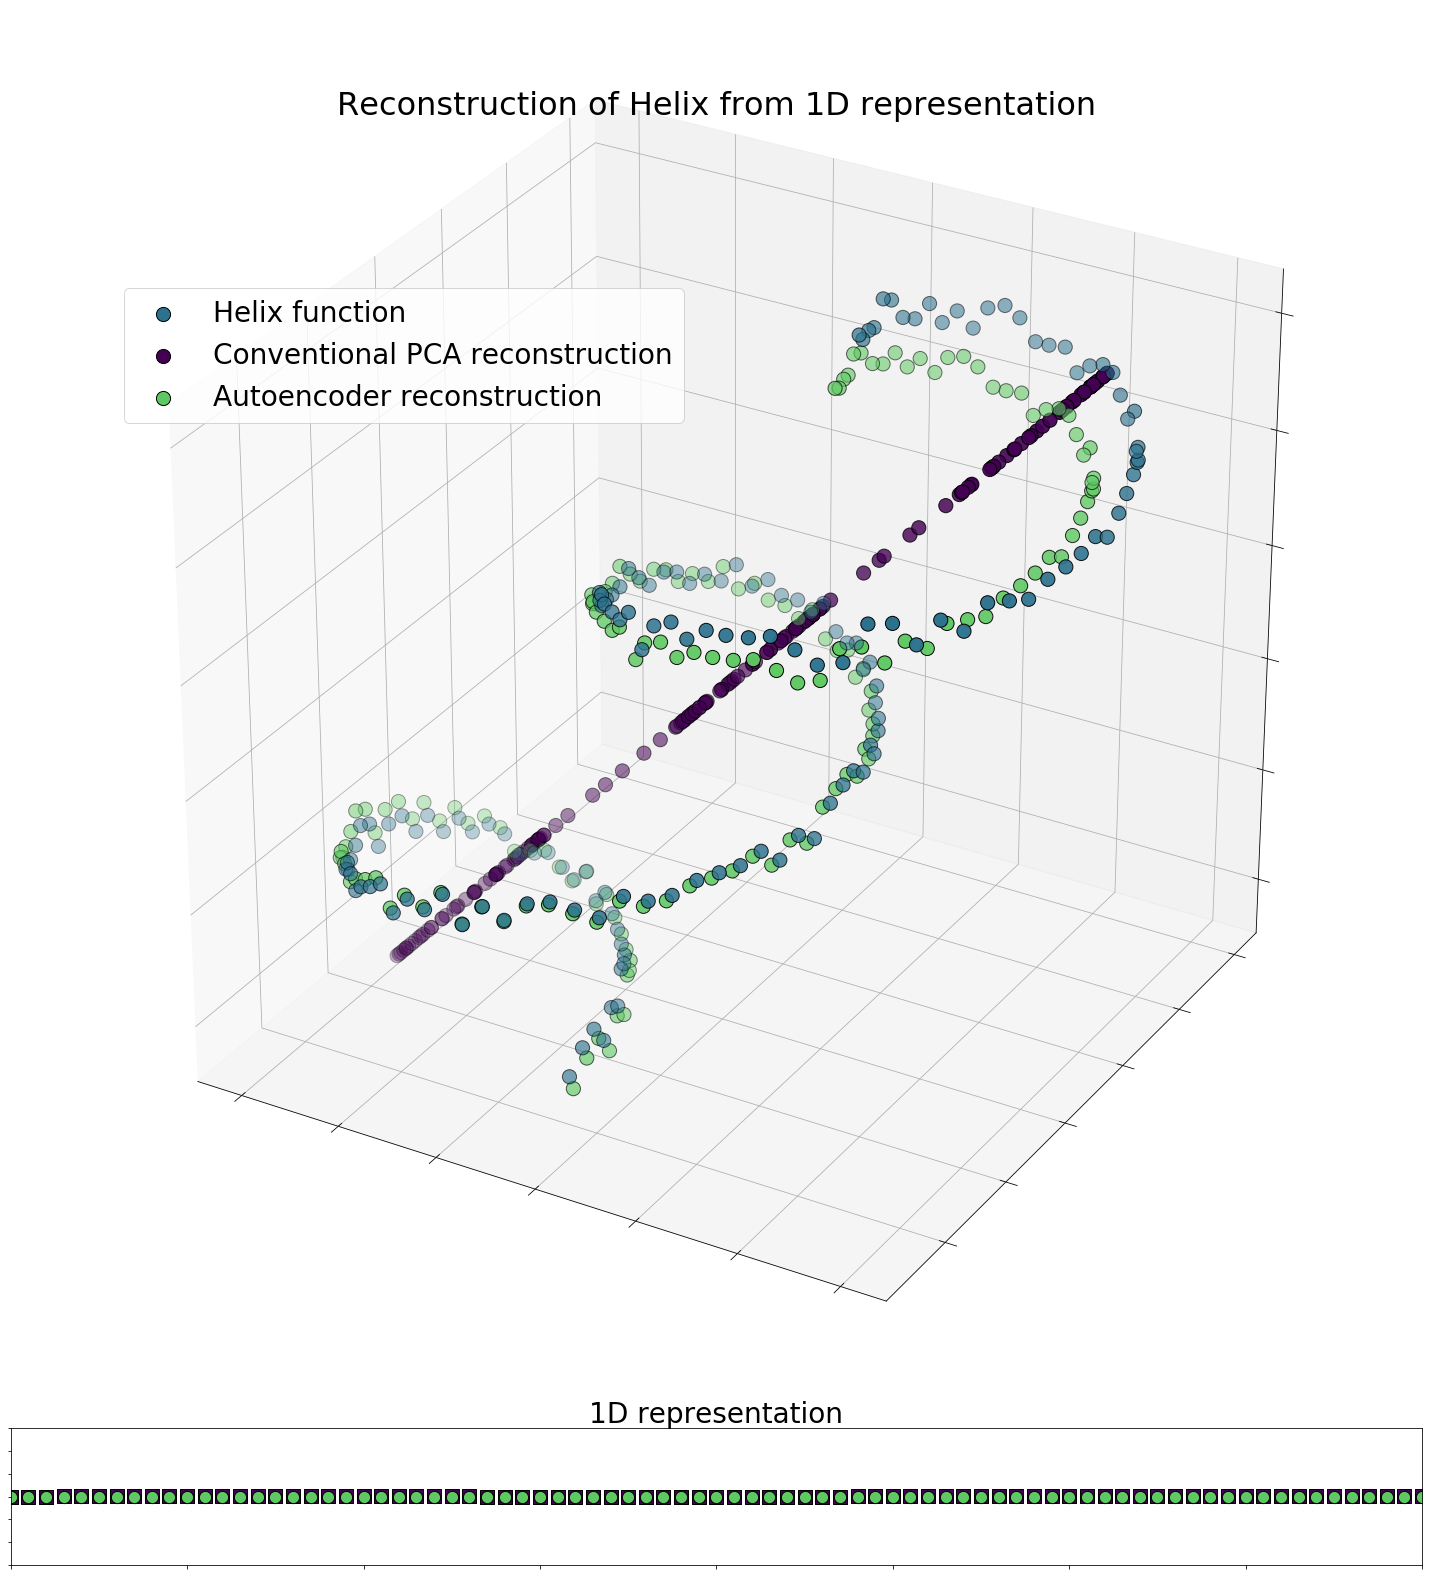

Figure 1: Decomposition and reconstitution of a 3D helix function into 1D with PCA vs. a Neural Network Autoencoder. Here we can see the limitations of linear dimensionality reduction. Even though both PCA and the neural network decompose the helix to essentially same evenly spaced 1D representation, PCA is only able to reconsitute a sloped line approximation of the helix while the NN autoncoder learns a close approximation of function underlying the helix shape.


In [4]:
# Fig. 1: PCA vs NN fit of helical function

# define a helix function and add a slop and noise:
# x = a*cost(t)+ m*t
# y = a*sin(t) + m*t
# z = b*t
a = 10
b = 0.1
m = 1.5
noise = 0.1
T = 16
dt = 0.1
myHelix = helix(a,b,m,0,T,dt)
myHelix1 = helix(a,b,m,noise,T,dt)

# build a simple nn-autoencoder network for 3d to 1d decomposition

hlSize = 3
codeSize = 1
nVisible = 3

epochs = 3000
dispIt = 3000
lR=1e-1
myMom=1e-1
fs=32 # font size

#placeholders
inputs = tf.placeholder("float",[None,nVisible])

myBias = 0

# Weights
w1 = tf.Variable(tf.truncated_normal([nVisible,hlSize],stddev=0.05),name='w1')
w2 = tf.Variable(tf.truncated_normal([hlSize,hlSize],stddev=0.05),name='w2')
w3 = tf.Variable(tf.truncated_normal([hlSize,hlSize],stddev=0.05),name='w3')
w4 = tf.Variable(tf.truncated_normal([hlSize,codeSize],stddev=0.05),name='w4')
w5 = tf.Variable(tf.truncated_normal([codeSize,hlSize],stddev=0.05),name='w5')
w6 = tf.Variable(tf.truncated_normal([hlSize,hlSize],stddev=0.05),name='w5')
w7 = tf.Variable(tf.truncated_normal([hlSize,hlSize],stddev=0.05),name='w7')
w8 = tf.Variable(tf.truncated_normal([hlSize,nVisible],stddev=0.05),name='w8')
def nlPCA(inputs):
    """autoencoder"""
    # Encode input
    data1 = inputs
    H1 = tf.nn.tanh(tf.matmul(data1,w1))#+myBias
    H2 = tf.nn.tanh(tf.matmul(H1,w2))#+myBias
    H3 = tf.nn.tanh(tf.matmul(H2,w3))#+myBias
    HC= tf.nn.tanh(tf.matmul(H3,w4))#+myBias
    H5 = tf.nn.tanh(tf.matmul(HC,w5))#+myBias
    H6 = tf.nn.tanh(tf.matmul(H5,w6))#+myBias
    H7 = tf.nn.tanh(tf.matmul(H6,w7))#+myBias
    myRecon = (tf.matmul(H1,w8))
    return myRecon, HC

# define loss and set momentum optimizer 
myRecon, myCodes = nlPCA(inputs)
loss = tf.sqrt(tf.reduce_mean(tf.pow((inputs-myRecon),2)))
                    
trainOp = tf.train.MomentumOptimizer(learning_rate=lR,
                                     momentum=myMom,
                                     name='momOp').minimize(loss)
           

# Pre-condition the helix data
myMaxX = np.max(myHelix1[:,0])
myMaxY = np.max(myHelix1[:,1])
myMaxZ = np.max(myHelix1[:,2])

myHelixNN = np.array([myHelix1[:,0]/myMaxX,myHelix1[:,1]/myMaxY,myHelix1[:,2]/myMaxZ])
#myHelixNN=2*(myHelixNN.T-0.5)
myHelixNN = myHelixNN.T
print(np.shape(myHelixNN))
minMeanMax(myHelixNN)


def fitHel():
    with tf.Session() as sess:
        tf.set_random_seed(1)
        #tf.global_variables_initializer()
        tf.initialize_all_variables().run()

        
        for i in range(epochs):
                sess.run(trainOp, feed_dict = {inputs: myHelixNN})
                if ((i%dispIt) == 0):
                    print("loss epoch %i = %.5e " % (i,np.mean(sess.run(loss, feed_dict={inputs: myHelix1}))))


        myGen =   sess.run(myRecon, feed_dict={inputs: myHelixNN})
        encodes =   sess.run(myCodes, feed_dict={inputs: myHelixNN})
                
        #Perform conventional PCA
        myPCA = sklearn.decomposition.PCA(n_components=1)
        myFit = myPCA.fit(myHelixNN)
        
        # Transformed to 1D
        myXform = myFit.fit_transform(myHelixNN)
        # Reconstructed
        myOriginal = myFit.inverse_transform(myXform)
        
        # Print out errors for each reconstruction
        lossPCA = (np.mean(((myHelixNN-myOriginal)**2)))
        lossNLPCA = (np.mean(((myHelixNN-myGen)**2)))
        print("\nConventional PCA MSE: %.3e"%(lossPCA))
        print("non-linear PCA (neural network autoencoder) MSE: %.3e"%(lossNLPCA))
        #myMean = np.mean(myHelixNN)
        #myVarTot = np.sum((myMean-myHelixNN)**2)
        #myVarResPCA = np.sum((myOriginal-myHelixNN)**2)
        #myVarResNN = np.sum((myGen-myHelixNN)**2)
        myR2NN = r2(myHelixNN,myGen)#1-myVarResNN / myVarTot
        myR2PCA = r2(myHelixNN,myOriginal)#1-myVarResPCA/myVarTot
        print('Conventional PCA R^2 = %.3f, Autoencoder R^2 = %.3f'%(myR2PCA,myR2NN))
        
        figHel = plt.figure(figsize=(20, 22)) 
        gs = matplotlib.gridspec.GridSpec(2,1, height_ratios=[10, 1]) 
        axHel0 = plt.subplot(gs[0],projection='3d')
        axHel1 = plt.subplot(gs[1])
        axHel0.scatter(myHelixNN[:,0],myHelixNN[:,1],myHelixNN[:,2],s=200,edgecolor='black',color=C2)
        axHel0.scatter(myOriginal[:,0],myOriginal[:,1],myOriginal[:,2],s=200,edgecolor='black',color=C1)
        axHel0.scatter(myGen[:,0],myGen[:,1],myGen[:,2],s=200,edgecolor='black',color=C3)
        #axHel1.plot(myXform)
        
        axHel1.scatter(np.arange(0,160),myXform,s=200,marker='s',edgecolor='black',color=C1)
        axHel1.scatter(np.arange(0,160),encodes,s=150,edgecolor='black',color=C3)
        axHel1.axis([60,140,-60,60])
        axHel1.set_xticklabels([])
        axHel1.set_yticklabels([])
        axHel0.set_xticklabels([])
        axHel0.set_yticklabels([])
        axHel0.set_zticklabels([])
        axHel1.set_title('1D representation',fontsize=fs-4)
        axHel0.set_title('Reconstruction of Helix from 1D representation',fontsize=fs)
        axHel0.legend(['Helix function','Conventional PCA reconstruction','Autoencoder reconstruction'],fontsize=fs-4,loc=[.08,0.7])
        plt.tight_layout()
       #plt.savefig('./figs/fig1HelixRecon.png')
        plt.show()

fitHel()
print("Figure 4: Decomposition and reconstitution of a 3D helix function into 1D with PCA vs. a Neural Network Autoencoder. Here we can see the limitations of linear dimensionality reduction. Even though both PCA and the neural network decompose the helix to essentially same evenly spaced 1D representation, PCA is only able to reconsitute a sloped line approximation of the helix while the NN autoncoder learns a close approximation of function underlying the helix shape.")

In [44]:
#PCA$>$LDA & 0.9278 & 0.9342 & 0.9235 & 0.9463 & 0.7630 & 0.0221 \\
#MLP & 0.9833 & 0.9784 & 0.9909 & 0.9784 & 0.9891 & 0.0015  \\
#Improvement & 0.9833 & 0.9784 & 0.9909 & 0.9784 & 0.9891 & 0.0015  \\
#Improvements for DU145/PNT2


print('improvement acc = %.3f, prec = %.3f, rec = %.3f, spec = %.3f, r2 = %.3f, MSE = %.3f'%
      (0.983/0.927, 0.978/0.934, 0.990/0.923, 0.978/0.946, 0.989/0.763, 1/(0.0015/0.022)))
np.sqrt(14.67)

improvement acc = 1.060, prec = 1.047, rec = 1.073, spec = 1.034, r2 = 1.296, MSE = 14.667


3.8301436004411116

In [9]:
#Improvements for doxo

print('doxo improvement acc = %.3f, prec = %.3f, rec = %.3f, spec = %.3f, r2 = %.3f, MSE = %.3f'%
      (0.925/0.2884, 0.9736/0.6983, 0.9467/0.3253, np.sqrt(-1) , 0.8597/0.9319, 1/(0.004068/0.0196)))


print('\n 5 component doxo improvement acc = %.3f, prec = %.3f, rec = %.3f, spec = %.3f, r2 = %.3f, MSE = %.3f'%
      (0.925/0.5613, 0.9736/0.8, 0.9467/0.5714, np.sqrt(-1) , 0.8597/0.8345, 1/(0.004068/0.05804)))


doxo improvement acc = 3.207, prec = 1.394, rec = 2.910, spec = nan, r2 = 0.923, MSE = 4.818

 5 component doxo improvement acc = 1.648, prec = 1.217, rec = 1.657, spec = nan, r2 = 1.030, MSE = 14.267


/home/main/anaconda3/envs/lV/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sqrt
  after removing the cwd from sys.path.
/home/main/anaconda3/envs/lV/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in sqrt
  


In [53]:
pop = 175e6
inc = 0.15
falsePos = 0.05
falseNeg = 0.025

print((pop*falseNeg*(1-inc)))
print((pop*falsePos*inc))

accuracy / precision/ recall / specificity / r2 /mse
#PCA$>$LDA & 0.9278 & 0.9342 & 0.9235 & 0.9463 & 0.7630 & 0.0221 \\
#MLP & 0.9833 & 0.9784 & 0.9909 & 0.9784 & 0.9891 & 0.0015  \\

3718750.0
1312500.0


In [69]:
pop = 1e5
inc = 119.8

precNN = 0.9784
precPCA = 0.9342
recNN = 0.9909
recPCA = 0.9235
specNN = 0.9784
specPCA = 0.9463

truePosNN = recNN * pop
truePosPCA = recPCA * pop

trueNegNN = specNN * pop
trueNegPCA = specPCA * pop

falsePosNN = (pop - inc) - (pop * specNN)
falsePosPCA = (pop - inc)  - (pop* specPCA)

falseNegNN = inc - recNN*(inc) 
falseNegPCA = inc - recPCA*(inc) 

print('PCA>LDA false pos. = %.3f, false neg. = %.3f'%(falsePosPCA,falseNegPCA))
print('MLP false pos. = %.3f, false neg. = %.3f'%(falsePosNN,falseNegNN))

#F1 = 2TP / (2TP + FP + FN)
F1NN = 2*truePosNN / (2*truePosNN + falsePosNN + falseNegNN)
print(F1NN)

F1PCA = 2*truePosPCA / (2*truePosPCA + falsePosPCA + falseNegPCA)
print(F1PCA)
print(F1NN/F1PCA)

PCA>LDA false pos. = 5250.200, false neg. = 9.165
MLP false pos. = 2040.200, false neg. = 1.090
0.9898048295555139
0.972313211784499
1.0179896946364764


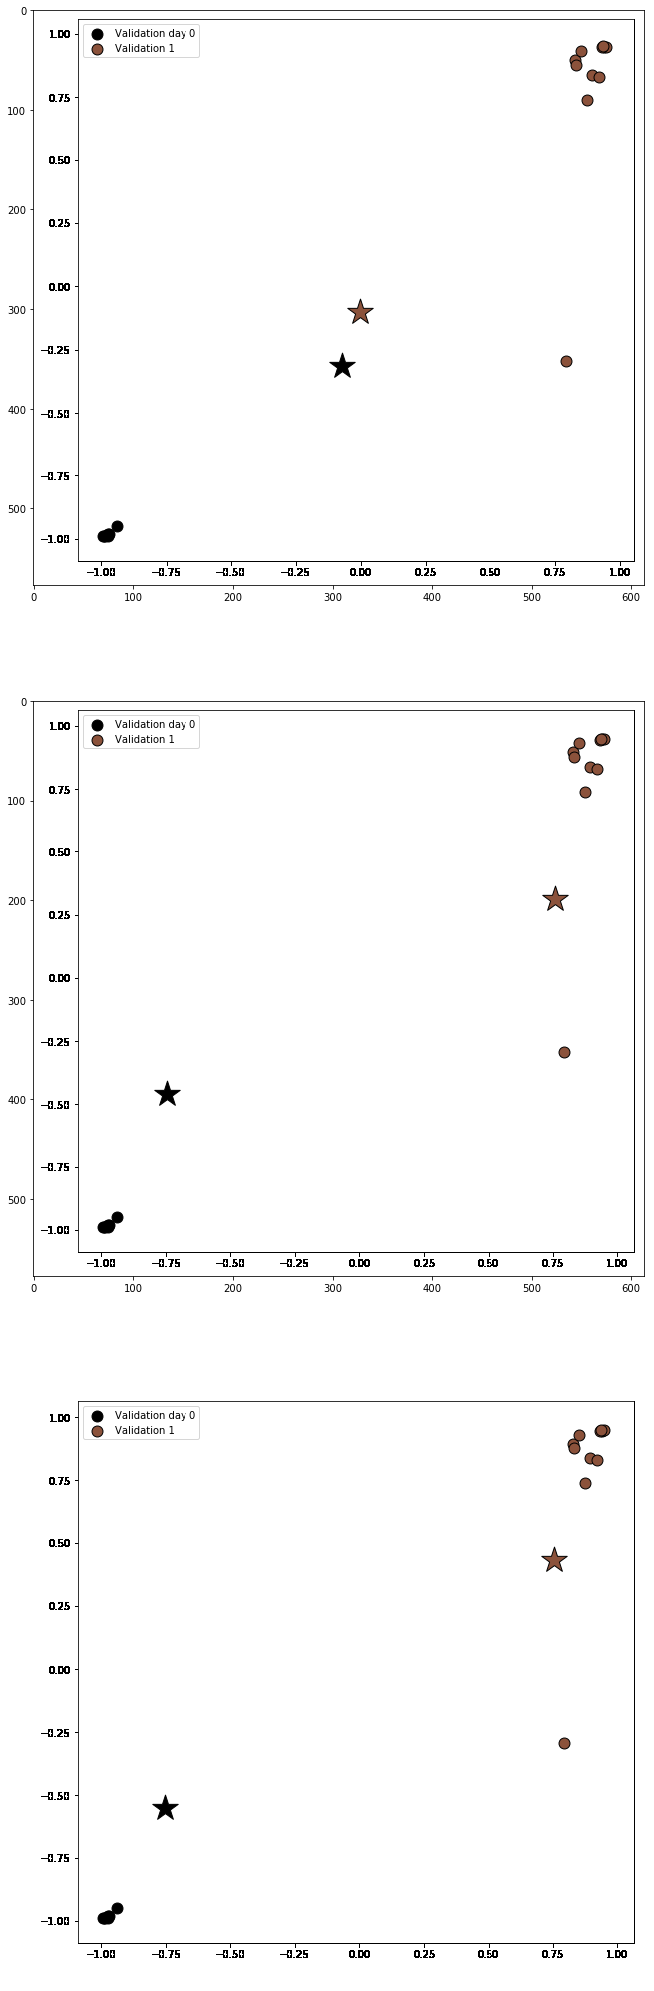

In [23]:
import cv2
cl1 = cv2.imread('/home/main/Desktop/Desktopception/cognitiveComputationalMicroscopy/chapter3/results/dupnt145/train2CC_0.png')
cl2 = cv2.imread('/home/main/Desktop/Desktopception/cognitiveComputationalMicroscopy/chapter3/results/dupnt145/train2CC_1.png')
cl3 = cv2.imread('/home/main/Desktop/Desktopception/cognitiveComputationalMicroscopy/chapter3/results/dupnt145/train2CC_2.png')

plt.figure(figsize=(18,36))
plt.subplot(311)
plt.imshow(cl1)

plt.subplot(312)
plt.imshow(cl2)

plt.subplot(313)
plt.imshow(cl3)
plt.axis('off')
plt.show()